In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras import Model
import unicodedata
import time

In [24]:
nhop

275

In [2]:
n_mels = 80
fs = 22050
frame_length_ms=50
frame_shift_ms=12.5
nsc = int(22050 * frame_length_ms / 1000)
nov = nsc - int(22050 * frame_shift_ms / 1000)
nhop = int(22050 * frame_shift_ms / 1000)
eps = 1e-10
db_ref = 100

chars = ''' ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz!\'\"()[],-.:;?&'''

num_tokens = len(chars)

embed_size = 256

K = 16

num_conv1d_filters = 128

prenet_size = [256, 128]

num_enc_proj_filters = [128, 128]

enc_highway_depth = 128

enc_bidirection_rnn_depth = 128 # 128 * 2

attention_depth = 128

dec_rnn_depth = [256, 256]

attention_rnn_depth = 256

dec_prenet_size = [256, 128]

r = 5

In [3]:
meta_path = "../datasets/metadata.csv"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

dataset_size = len(metadata)

In [4]:
text_len = np.asarray(list(map(lambda x: len(x[1]), metadata)))

In [5]:
metadata = metadata[text_len <= 64]

def HasNumber(string):
    for letter in string:
        if letter.isdigit():
            return True
        if letter == '&':
            return True
        
    return False

mask = np.asarray(list(map(lambda x: HasNumber(x[1]), metadata)))
metadata = metadata[~mask]

In [6]:
for text in metadata[:, 1]:
    for char in text:
        if char not in chars:
            print(char)
            print(text)

print(len(chars))

67


In [7]:
wave_name_list = []

for data in metadata:
    wav_name = '{}.wav'.format(data[0])
    wave_name_list.append(wav_name)
    
data_folder = "../datasets/wavs"
specgram_folder = "../datasets/specgrams"
mel_folder = "../datasets/mels"

In [8]:
"""

Preprocessing Step

"""

# for wav_name in tqdm(wave_name_list):
#     wav_path = os.path.join(data_folder, wav_name)
    
#     npy_name = wav_name.replace('.wav', '.npy')
    
#     specgram_path = os.path.join(specgram_folder, npy_name)
#     mel_path = os.path.join(mel_folder, npy_name)
    
#     y, sr = librosa.core.load(wav_path)
    
#     f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)

#     Sxx = np.abs(Zxx)
#     Sxx = np.maximum(Sxx, eps)

#     # plt.figure(figsize=(20,20))
#     # plt.imshow(20*np.log10(Sxx), origin='lower')
#     # plt.colorbar()
#     # plt.show()

#     mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)

#     mel_specgram = np.matmul(mel_filters, Sxx)

#     log_specgram = 20*np.log10(Sxx)

#     norm_log_specgram = (log_specgram + db_ref) / db_ref

#     log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))

#     norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref
    
# #     np.save(specgram_path, norm_log_specgram)
# #     np.save(mel_path, norm_log_mel_specgram)
#     np.save(specgram_path, Sxx)
#     np.save(mel_path, norm_log_mel_specgram)
    
#     print(norm_log_mel_specgram.shape[1])
    

#     plt.figure(figsize=(16,9))
#     plt.imshow(Sxx, origin='lower', aspect='auto')
#     plt.colorbar()
#     plt.show()

#     plt.figure(figsize=(16,9))
#     plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
#     plt.colorbar()
#     plt.show()    
#     break

'\n\nPreprocessing Step\n\n'

In [9]:
embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size)


def initialize_GO_frame(batch_size, n_mels):
    return tf.zeros((batch_size, r, n_mels))


def flatten_r_frame(input_tensor, batch_size):
    return tf.reshape(input_tensor, [batch_size, 1, -1])


class Conv1D_Bank(tf.keras.Model):
    
    def __init__(self, num_filters, K):
        super(Conv1D_Bank, self).__init__()
        
        self.K = K
        
        self.conv1d_filters = [tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=k+1, filters=num_filters, padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu')])
                               for k in range(K)]
    
    @tf.function
    def call(self, input_tensor):
        
        intermediate_results = []
        
        for k in range(self.K):
            conv_k_result = self.conv1d_filters[k](input_tensor)
            intermediate_results.append(conv_k_result)
        
        output_tensor = tf.concat(intermediate_results, axis = -1) 
        
        return output_tensor
    
class HighwayNet(tf.keras.Model):
    def __init__(self, num_units):
        super(HighwayNet, self).__init__()
        self.T = tf.keras.layers.Dense(units=num_units, activation='sigmoid',
                                        bias_initializer=tf.constant_initializer(-1.0))
        self.H = tf.keras.layers.Dense(units=num_units, activation='relu')

    @tf.function
    def call(self, input_tensor):
        output_tensor = self.H(input_tensor) * self.T(input_tensor) + input_tensor * (1 - self.T(input_tensor))
        return output_tensor
    
'''
https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention

'''
    
class BahdanauAttention(tf.keras.Model):
    def __init__(self):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(attention_depth)
        self.W2 = tf.keras.layers.Dense(attention_depth)
        self.V = tf.keras.layers.Dense(1)

    @tf.function
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.expand_dims(context_vector, axis=1)

        return context_vector, attention_weights
    
class ResidualGRU(tf.keras.Model):
    def __init__(self, units, return_sequences, recurrent_initializer='glorot_uniform'):
        super(ResidualGRU, self).__init__()
        self.units = units
        self.gru_layer = tf.keras.layers.GRU(units, return_sequences=True, recurrent_initializer=recurrent_initializer)

#   @tf.function
    def call(self, input_tensor, initial_state):
        output_tensor = self.gru_layer(input_tensor, initial_state = initial_state)
        
        residual_ouput_tensor = tf.add(output_tensor, input_tensor[:, :, :self.units])
        
        return residual_ouput_tensor
    
    
class StackedResidualRNN(tf.keras.Model):
    def __init__(self):
        super(StackedResidualRNN, self).__init__()
        self.depth = dec_rnn_depth
        self.residual_grues = [ResidualGRU(dec_rnn_depth[0], return_sequences=True, recurrent_initializer='glorot_uniform'),
                               ResidualGRU(dec_rnn_depth[1], return_sequences=True, recurrent_initializer='glorot_uniform')]

#   @tf.function
    def call(self, input_tensor, hidden_states):

        for i, residual_gru in enumerate(self.residual_grues):
            output_tensor = residual_gru(input_tensor, initial_state=hidden_states[i])
            hidden_states[i] = tf.reshape(output_tensor, [output_tensor.shape[0], -1])

        return output_tensor, hidden_states
    
    def initialize_hidden_states(self, batch_size):
        return [tf.zeros((batch_size, dec_rnn_depth[0])), tf.zeros((batch_size, dec_rnn_depth[1]))]      

class AttentionRNN(tf.keras.Model):
    def __init__(self):
        super(AttentionRNN, self).__init__()
        self.depth = attention_rnn_depth
        self.gru_cell = tf.keras.layers.GRU(self.depth, return_sequences=True, recurrent_initializer='glorot_uniform')

    @tf.function
    def call(self, input_tensor, initial_state):
        output_tensor = self.gru_cell(input_tensor, initial_state=initial_state)
        hidden_state = output_tensor
        hidden_state = tf.reshape(hidden_state, [hidden_state.shape[0], -1])

        return output_tensor, hidden_state
    
    def initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.depth))      

class DecoderRNN(tf.keras.Model):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        self.dec_rnn_depth = dec_rnn_depth
        self.att_rnn_depth = attention_rnn_depth
        
        self.attention_rnn_layer = AttentionRNN()
        self.residual_rnn_layers = StackedResidualRNN()
        
#   @tf.function
    def call(self, input_tensor, hidden_states, context_vector):
                
        state, hidden_states[0] = self.attention_rnn_layer(input_tensor, initial_state=hidden_states[0])
        
        res_rnn_input_tensor = tf.concat([state, context_vector], axis=-1)
        
        output_tensor, hidden_states[1:3] = self.residual_rnn_layers(res_rnn_input_tensor, hidden_states[1:3])
        
        return output_tensor, hidden_states
    
    def initialize_hidden_states(self, batch_size):
        hidden_states = [self.attention_rnn_layer.initialize_hidden_state(batch_size)] + self.residual_rnn_layers.initialize_hidden_states(batch_size)
        return hidden_states
    
class DecoderPrenet(tf.keras.Model):
    def __init__(self):
        super(DecoderPrenet, self).__init__()
        self.decoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(dec_prenet_size[0]),
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Activation('relu'),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(dec_prenet_size[1]),
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Activation('relu'),
                         tf.keras.layers.Dropout(0.5)])
       
    @tf.function
    def call(self, input_tensor):
        output_tensor = self.decoder_prenet_layer(input_tensor)
        return output_tensor
        
class MelPredictor(tf.keras.Model):
    def __init__(self):
        super(MelPredictor, self).__init__()
        self.mel_dense_layers = [tf.keras.layers.Dense(n_mels) for i in range(r)]
        self.r = r
    
    @tf.function
    def call(self, input_tensor):
        
        output = []
        
        for i, dense_layer in enumerate(self.mel_dense_layers):
            output.append(dense_layer(input_tensor))
            
        output_tensor = tf.concat(output, axis=1)
        
        return output_tensor
    
class CBHG(tf.keras.Model):
    def __init__(self, num_conv1d_filters, K, num_proj_filters, highway_depth, bidirection_rnn_depth):
        super(CBHG, self).__init__()
        self.conv1d_bank = Conv1D_Bank(num_conv1d_filters, K)
        self.max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        self.projection_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[0], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu'),
                                                   tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[1], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('linear')
                                                   ])
        
        self.highway_preprocess_layer = tf.keras.layers.Dense(highway_depth)
        
        self.highway_layer = tf.keras.Sequential([HighwayNet(highway_depth) for i in range(4)])
        
        self.bi_gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

    @tf.function
    def call(self, input_tensor):
        
        bank_output = self.conv1d_bank(input_tensor)
        max_pool_output = self.max_pooling_layer(bank_output) 
        projection_output = self.projection_layer(max_pool_output)
        
        residual_output = tf.add(projection_output, input_tensor)
        
        highway_intput = self.highway_preprocess_layer(residual_output)
        highway_output = self.highway_layer(highway_intput)
        output_tensor = self.bi_gru_layer(highway_output)
        
        return output_tensor
        

class Tacotron():
    
    def __init__(self):
        super(Tacotron, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size) 

        self.encoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(prenet_size[0], input_shape=(None, embed_size)),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Activation('relu'),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(prenet_size[1]),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Activation('relu'),
                                 tf.keras.layers.Dropout(0.5)], name='Encoder_Prenet')
    
        self.encoder_conv_bank_layer = Conv1D_Bank(num_conv1d_filters, K)
        
        self.enc_max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        
        self.enc_proj_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[0], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu'),
                                                   tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[1], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('linear')
                                                   ])
        
        self.enc_highway_layer = tf.keras.Sequential([HighwayNet(128) for i in range(4)])
    
        self.enc_bi_rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(enc_bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

        self.attention_layer = BahdanauAttention()
        
        self.decoder_rnn_layer = DecoderRNN()
        
        self.decoder_prenet_layer = DecoderPrenet()
        
        self.mel_pred_layer = MelPredictor()
        
        self.post_processing_cbhg = CBHG(128, 8, (256, 80), 128, 128)
        
        self.final_dense_layer = tf.keras.layers.Dense(552)
        
        self.L1 = tf.keras.losses.MeanAbsoluteError()
        
#         self.L2 = tf.keras.losses.MeanSquaredError()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
     
    @tf.function
    def train(self, mel, linear, input_tensor):
        
        batch_size = input_tensor.shape[0]
        sequence_length = input_tensor.shape[1]
        
        with tf.GradientTape(persistent=True) as tape:
            
            embedded = self.embedding_layer(input_tensor)
            encoded = self.encoder_prenet_layer(embedded)
            banked = self.encoder_conv_bank_layer(encoded)
            max_pooled = self.enc_max_pooling_layer(banked)
            projected = self.enc_proj_layer(max_pooled)
            residual_output = tf.add(encoded, projected)
            highway_output = self.enc_highway_layer(residual_output)
            encoder_output = self.enc_bi_rnn_layer(highway_output)
            
            hidden_state = encoder_output[:, -1, :]
            hidden_states = self.decoder_rnn_layer.initialize_hidden_states(batch_size)
            hidden_states[0] = hidden_state

            frames = []
            frame = initialize_GO_frame(batch_size, n_mels)

            for i in range(sequence_length):
                flat_frame = flatten_r_frame(frame, batch_size)
                decoder_rnn_input = self.decoder_prenet_layer(flat_frame)
                context_vector, _ = self.attention_layer(hidden_states[0], encoder_output)
                decoder_rnn_output, hidden_states = self.decoder_rnn_layer(decoder_rnn_input, hidden_states, context_vector)

                mel_frame = self.mel_pred_layer(decoder_rnn_output)
                
                frames.append(mel_frame)
                
                #frame = mel_frame #No force teaching
                
                frame = mel[:, r*(i):r*(i+1), :] # Force teaching
                
            
            mel_pred = tf.concat(frames, axis=1)
            post_cbhg_output = self.post_processing_cbhg(mel_pred)
            linear_pred = self.final_dense_layer(post_cbhg_output)
            
            mel_length = min(mel_pred.shape[1], mel.shape[1])
            linear_length = min(linear_pred.shape[1], linear.shape[1])

            mel_loss = self.L1(mel[:, :mel_length, :], mel_pred[:, :mel_length, :])
            linear_loss = self.L1(linear[:, :linear_length, :], linear_pred[:, :linear_length, :])
            total_loss = mel_loss + linear_loss
            
            print("Loss Calculated")
            print(time.strftime("%Hh %Mm %Ss"))
            
            variables = self.embedding_layer.trainable_variables + self.encoder_prenet_layer.trainable_variables + \
            self.encoder_conv_bank_layer.trainable_variables + self.enc_max_pooling_layer.trainable_variables + \
            self.enc_proj_layer.trainable_variables + self.enc_highway_layer.trainable_variables + \
            self.enc_bi_rnn_layer.trainable_variables + self.attention_layer.trainable_variables + \
            self.decoder_rnn_layer.trainable_variables + self.decoder_prenet_layer.trainable_variables + \
            self.mel_pred_layer.trainable_variables + self.post_processing_cbhg.trainable_variables + \
            self.final_dense_layer.trainable_variables
            
            gradients = tape.gradient(total_loss, variables)
            
            self.optimizer.apply_gradients(zip(gradients, variables))

        
        return total_loss, (mel_pred[0], linear_pred[0], mel[0], linear[0])
    
#         return total_loss / (r * sequence_length), (mel_pred[0], linear_pred[0], mel[0], linear[0])
        
        

In [10]:
# embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size)


# def initialize_GO_frame(batch_size, n_mels):
#     return tf.zeros((batch_size, r, n_mels))


# def flatten_r_frame(input_tensor, batch_size):
#     return tf.reshape(input_tensor, [batch_size, 1, -1])


# class Conv1D_Bank(tf.keras.Model):
    
#     def __init__(self, num_filters, K):
#         super(Conv1D_Bank, self).__init__()
        
#         self.K = K
        
#         self.conv1d_filters = [tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=k+1, filters=num_filters, padding='same'),
#                                                    tf.keras.layers.BatchNormalization(),
#                                                    tf.keras.layers.Activation('relu')])
#                                for k in range(K)]
    
#     @tf.function
#     def call(self, input_tensor):
        
#         intermediate_results = []
        
#         for k in range(self.K):
#             conv_k_result = self.conv1d_filters[k](input_tensor)
#             intermediate_results.append(conv_k_result)
        
#         output_tensor = tf.concat(intermediate_results, axis = -1) 
        
#         return output_tensor
    
# class HighwayNet(tf.keras.Model):
#     def __init__(self, num_units):
#         super(HighwayNet, self).__init__()
#         self.T = tf.keras.layers.Dense(units=num_units, activation='sigmoid',
#                                         bias_initializer=tf.constant_initializer(-1.0))
#         self.H = tf.keras.layers.Dense(units=num_units, activation='relu')

#     @tf.function
#     def call(self, input_tensor):
#         output_tensor = self.H(input_tensor) * self.T(input_tensor) + input_tensor * (1 - self.T(input_tensor))
#         return output_tensor
    
# '''
# https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention

# '''
    
# class BahdanauAttention(tf.keras.Model):
#     def __init__(self):
#         super(BahdanauAttention, self).__init__()
#         self.W1 = tf.keras.layers.Dense(attention_depth)
#         self.W2 = tf.keras.layers.Dense(attention_depth)
#         self.V = tf.keras.layers.Dense(1)

#     @tf.function
#     def call(self, query, values):
#         hidden_with_time_axis = tf.expand_dims(query, 1)

#         score = self.V(tf.nn.tanh(
#             self.W1(values) + self.W2(hidden_with_time_axis)))

#         attention_weights = tf.nn.softmax(score, axis=1)

#         context_vector = attention_weights * values
#         context_vector = tf.reduce_sum(context_vector, axis=1)
#         context_vector = tf.expand_dims(context_vector, axis=1)

#         return context_vector, attention_weights
    
# class ResidualGRU(tf.keras.Model):
#     def __init__(self, units, return_sequences, recurrent_initializer='glorot_uniform'):
#         super(ResidualGRU, self).__init__()
#         self.units = units
#         self.gru_layer = tf.keras.layers.GRU(units, return_sequences=True, recurrent_initializer=recurrent_initializer)

# #   @tf.function
#     def call(self, input_tensor, initial_state):
#         output_tensor = self.gru_layer(input_tensor, initial_state = initial_state)
        
#         residual_ouput_tensor = tf.add(output_tensor, input_tensor[:, :, :self.units])
        
#         return residual_ouput_tensor
    
    
# class StackedResidualRNN(tf.keras.Model):
#     def __init__(self):
#         super(StackedResidualRNN, self).__init__()
#         self.depth = dec_rnn_depth
#         self.residual_grues = [ResidualGRU(dec_rnn_depth[0], return_sequences=True, recurrent_initializer='glorot_uniform'),
#                                ResidualGRU(dec_rnn_depth[1], return_sequences=True, recurrent_initializer='glorot_uniform')]

# #   @tf.function
#     def call(self, input_tensor, hidden_states):

#         for i, residual_gru in enumerate(self.residual_grues):
#             output_tensor = residual_gru(input_tensor, initial_state=hidden_states[i])
#             hidden_states[i] = tf.reshape(output_tensor, [output_tensor.shape[0], -1])

#         return output_tensor, hidden_states
    
#     def initialize_hidden_states(self, batch_size):
#         return [tf.zeros((batch_size, dec_rnn_depth[0])), tf.zeros((batch_size, dec_rnn_depth[1]))]      

# class AttentionRNN(tf.keras.Model):
#     def __init__(self):
#         super(AttentionRNN, self).__init__()
#         self.depth = attention_rnn_depth
#         self.gru_cell = tf.keras.layers.GRU(self.depth, return_sequences=True, recurrent_initializer='glorot_uniform')

#     @tf.function
#     def call(self, input_tensor, initial_state):
#         output_tensor = self.gru_cell(input_tensor, initial_state=initial_state)
#         hidden_state = output_tensor
#         hidden_state = tf.reshape(hidden_state, [hidden_state.shape[0], -1])

#         return output_tensor, hidden_state
    
#     def initialize_hidden_state(self, batch_size):
#         return tf.zeros((batch_size, self.depth))      

# class DecoderRNN(tf.keras.Model):
#     def __init__(self):
#         super(DecoderRNN, self).__init__()
#         self.dec_rnn_depth = dec_rnn_depth
#         self.att_rnn_depth = attention_rnn_depth
        
#         self.attention_rnn_layer = AttentionRNN()
#         self.residual_rnn_layers = StackedResidualRNN()
        
# #   @tf.function
#     def call(self, input_tensor, hidden_states, context_vector):
                
#         state, hidden_states[0] = self.attention_rnn_layer(input_tensor, initial_state=hidden_states[0])
        
#         res_rnn_input_tensor = tf.concat([state, context_vector], axis=-1)
        
#         output_tensor, hidden_states[1:3] = self.residual_rnn_layers(res_rnn_input_tensor, hidden_states[1:3])
        
#         return output_tensor, hidden_states
    
#     def initialize_hidden_states(self, batch_size):
#         hidden_states = [self.attention_rnn_layer.initialize_hidden_state(batch_size)] + self.residual_rnn_layers.initialize_hidden_states(batch_size)
#         return hidden_states
    
# class DecoderPrenet(tf.keras.Model):
#     def __init__(self):
#         super(DecoderPrenet, self).__init__()
#         self.decoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(dec_prenet_size[0]),
#                          tf.keras.layers.BatchNormalization(),
#                          tf.keras.layers.Activation('relu'),
#                          tf.keras.layers.Dropout(0.5),
#                          tf.keras.layers.Dense(dec_prenet_size[1]),
#                          tf.keras.layers.BatchNormalization(),
#                          tf.keras.layers.Activation('relu'),
#                          tf.keras.layers.Dropout(0.5)])
       
#     @tf.function
#     def call(self, input_tensor):
#         output_tensor = self.decoder_prenet_layer(input_tensor)
#         return output_tensor
        
# class MelPredictor(tf.keras.Model):
#     def __init__(self):
#         super(MelPredictor, self).__init__()
#         self.mel_dense_layers = [tf.keras.layers.Dense(n_mels) for i in range(r)]
#         self.r = r
    
#     @tf.function
#     def call(self, input_tensor):
        
#         output = []
        
#         for i, dense_layer in enumerate(self.mel_dense_layers):
#             output.append(dense_layer(input_tensor))
            
#         output_tensor = tf.concat(output, axis=1)
        
#         return output_tensor
    
# class CBHG(tf.keras.Model):
#     def __init__(self, num_conv1d_filters, K, num_proj_filters, highway_depth, bidirection_rnn_depth):
#         super(CBHG, self).__init__()
#         self.conv1d_bank = Conv1D_Bank(num_conv1d_filters, K)
#         self.max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
#         self.projection_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[0], padding='same'),
#                                                    tf.keras.layers.BatchNormalization(),
#                                                    tf.keras.layers.Activation('relu'),
#                                                    tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[1], padding='same'),
#                                                    tf.keras.layers.BatchNormalization(),
#                                                    tf.keras.layers.Activation('linear')
#                                                    ])
        
#         self.highway_preprocess_layer = tf.keras.layers.Dense(highway_depth)
        
#         self.highway_layer = tf.keras.Sequential([HighwayNet(highway_depth) for i in range(4)])
        
#         self.bi_gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

#     @tf.function
#     def call(self, input_tensor):
        
#         bank_output = self.conv1d_bank(input_tensor)
#         max_pool_output = self.max_pooling_layer(bank_output) 
#         projection_output = self.projection_layer(max_pool_output)
        
#         residual_output = tf.add(projection_output, input_tensor)
        
#         highway_intput = self.highway_preprocess_layer(residual_output)
#         highway_output = self.highway_layer(highway_intput)
#         output_tensor = self.bi_gru_layer(highway_output)
        
#         return output_tensor
        

# class Tacotron():
    
#     def __init__(self):
#         super(Tacotron, self).__init__()
        
#         self.embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size) 

#         self.encoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(prenet_size[0], input_shape=(None, embed_size)),
#                                  tf.keras.layers.BatchNormalization(),
#                                  tf.keras.layers.Activation('relu'),
#                                  tf.keras.layers.Dropout(0.5),
#                                  tf.keras.layers.Dense(prenet_size[1]),
#                                  tf.keras.layers.BatchNormalization(),
#                                  tf.keras.layers.Activation('relu'),
#                                  tf.keras.layers.Dropout(0.5)], name='Encoder_Prenet')
    
#         self.encoder_conv_bank_layer = Conv1D_Bank(num_conv1d_filters, K)
        
#         self.enc_max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        
#         self.enc_proj_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[0], padding='same'),
#                                                    tf.keras.layers.BatchNormalization(),
#                                                    tf.keras.layers.Activation('relu'),
#                                                    tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[1], padding='same'),
#                                                    tf.keras.layers.BatchNormalization(),
#                                                    tf.keras.layers.Activation('linear')
#                                                    ])
        
#         self.enc_highway_layer = tf.keras.Sequential([HighwayNet(128) for i in range(4)])
    
#         self.enc_bi_rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(enc_bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

#         self.attention_layer = BahdanauAttention()
        
#         self.decoder_rnn_layer = DecoderRNN()
        
#         self.decoder_prenet_layer = DecoderPrenet()
        
#         self.mel_pred_layer = MelPredictor()
        
#         self.post_processing_cbhg = CBHG(128, 8, (256, 80), 128, 128)
        
#         self.final_dense_layer = tf.keras.layers.Dense(552)
        
#         self.L1 = tf.keras.losses.MeanAbsoluteError()
        
# #         self.L2 = tf.keras.losses.MeanSquaredError()

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
     
#     @tf.function
#     def train(self, mel, linear, input_tensor):
        
#         batch_size = input_tensor.shape[0]
#         sequence_length = input_tensor.shape[1]
        
#         with tf.GradientTape(persistent=True) as tape:
            
#             embedded = self.embedding_layer(input_tensor)
#             encoded = self.encoder_prenet_layer(embedded)
#             banked = self.encoder_conv_bank_layer(encoded)
#             max_pooled = self.enc_max_pooling_layer(banked)
#             projected = self.enc_proj_layer(max_pooled)
#             residual_output = tf.add(encoded, projected)
#             highway_output = self.enc_highway_layer(residual_output)
#             encoder_output = self.enc_bi_rnn_layer(highway_output)
            
#             hidden_state = encoder_output[:, -1, :]
#             hidden_states = self.decoder_rnn_layer.initialize_hidden_states(batch_size)
#             hidden_states[0] = hidden_state

#             frames = []
#             frame = initialize_GO_frame(batch_size, n_mels)

#             for i in range(sequence_length):
#                 flat_frame = flatten_r_frame(frame, batch_size)
#                 decoder_rnn_input = self.decoder_prenet_layer(flat_frame)
#                 context_vector, _ = self.attention_layer(hidden_states[0], encoder_output)
#                 decoder_rnn_output, hidden_states = self.decoder_rnn_layer(decoder_rnn_input, hidden_states, context_vector)

#                 mel_frame = self.mel_pred_layer(decoder_rnn_output)
                
#                 frames.append(mel_frame)
                
#                 #frame = mel_frame #No force teaching
                
#                 frame = mel[:, r*(i):r*(i+1), :] # Force teaching

#                 mel_pred = tf.concat(frames, axis=1)
                
#                 post_cbhg_output = self.post_processing_cbhg(mel_frame)
#                 linear_pred = self.final_dense_layer(post_cbhg_output)
            
#                 if r*(i+1) <= mel.shape[1]:
#                     mel_loss = self.L1(mel[:, r*(i):r*(i+1), :], mel_frame)
#                     linear_loss = self.L1(linear[:, r*(i):r*(i+1), :], linear_pred)
#                     total_loss = mel_loss + linear_loss
                    
#                     print('Time taken for an epoch: {:.1f} sec'.format(time.time() - start))
#                     print(time.strftime("%Hh %Mm %Ss"))
            
#                     variables = self.embedding_layer.trainable_variables + self.encoder_prenet_layer.trainable_variables + \
#                     self.encoder_conv_bank_layer.trainable_variables + self.enc_max_pooling_layer.trainable_variables + \
#                     self.enc_proj_layer.trainable_variables + self.enc_highway_layer.trainable_variables + \
#                     self.enc_bi_rnn_layer.trainable_variables + self.attention_layer.trainable_variables + \
#                     self.decoder_rnn_layer.trainable_variables + self.decoder_prenet_layer.trainable_variables + \
#                     self.mel_pred_layer.trainable_variables + self.post_processing_cbhg.trainable_variables + \
#                     self.final_dense_layer.trainable_variables

#                     gradients = tape.gradient(total_loss, variables)

#                     self.optimizer.apply_gradients(zip(gradients, variables))
                    
#             del tape
        
#         return total_loss, (mel_pred[0], mel[0])
    
# #         return total_loss / (r * sequence_length), (mel_pred[0], linear_pred[0], mel[0], linear[0])
        
        

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False, char_level=True)
tokenizer.fit_on_texts(chars)

tokenized_texts = tokenizer.texts_to_sequences(metadata[:, 1])

def dataset_generator():
    for file_name, tokens in zip(metadata[:, 0], tokenized_texts):
        linear_path = os.path.join(specgram_folder, file_name + '.npy')
        mel_path = os.path.join(mel_folder, file_name + '.npy')
        mel_target = np.load(mel_path)
        linear_target = np.load(linear_path)
        yield mel_target.T, linear_target.T, tokens

    return

In [12]:
dataset = tf.data.Dataset.from_generator(dataset_generator, (tf.float32, tf.float32, tf.int32), output_shapes=(tf.TensorShape([None, n_mels]), tf.TensorShape([None, 552]),tf.TensorShape([None, ])))

# dataset.shuffle(dataset_size)

W0717 22:10:43.432529 19544 deprecation.py:323] From c:\users\jw\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [13]:
def element_length_function(mel, linear, tokens):
    key = tf.size(tokens)
    return key

batch_size = 64

sequence_lengths = [i + 1 for i in range(16, max_sequence_len, 16)]
batch_sizes = [batch_size for i in range(len(sequence_lengths) + 1)]

dataset = dataset.apply(tf.data.experimental.bucket_by_sequence_length(element_length_function, sequence_lengths, batch_sizes))
dataset = dataset.prefetch(64)

W0717 22:10:43.463537 19544 deprecation.py:323] From c:\users\jw\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\data\experimental\ops\grouping.py:193: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
# import warnings
# warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
tacotron = Tacotron()

23h 41m 16s
Time taken for an epoch #0: 11.6 sec
23h 41m 27s
tf.Tensor(0.056375355, shape=(), dtype=float32)


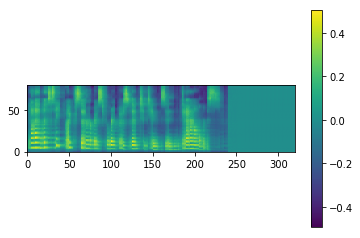

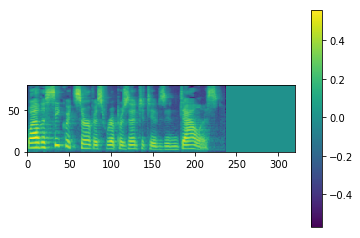

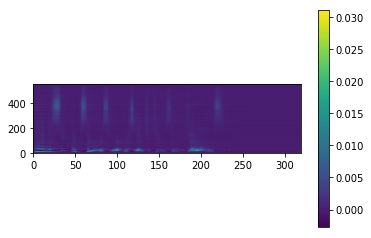

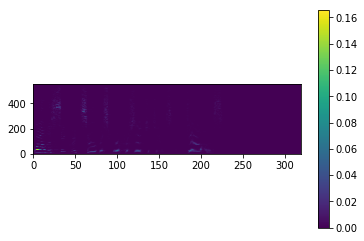

Time taken for an epoch #30: 11.7 sec
23h 47m 18s
tf.Tensor(0.05387288, shape=(), dtype=float32)


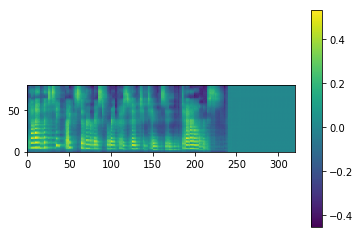

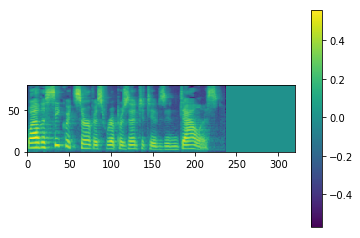

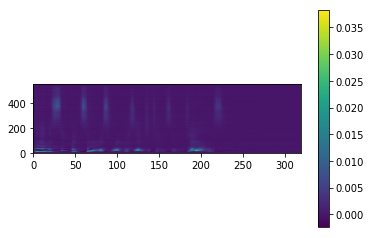

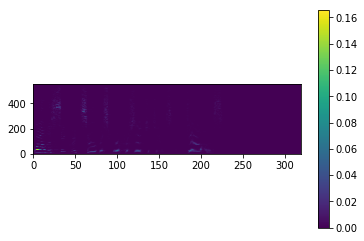

Time taken for an epoch #60: 11.6 sec
23h 53m 09s
tf.Tensor(0.051517766, shape=(), dtype=float32)


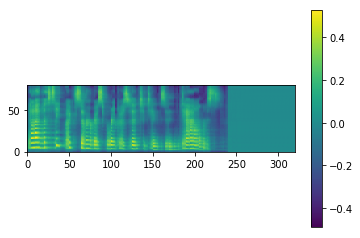

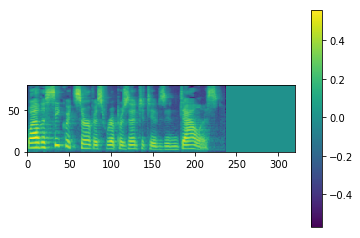

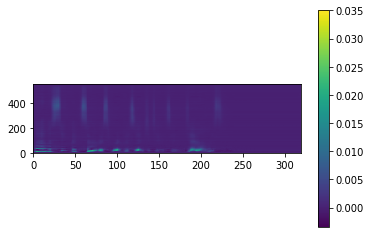

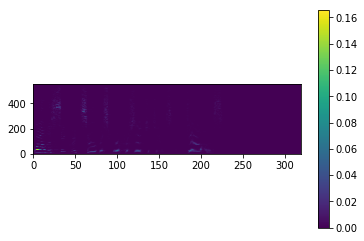

Time taken for an epoch #90: 11.6 sec
23h 59m 00s
tf.Tensor(0.048749223, shape=(), dtype=float32)


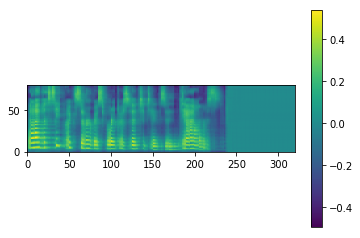

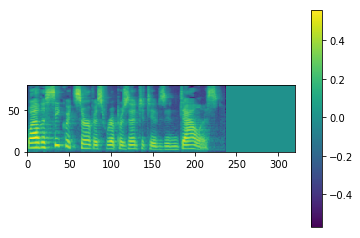

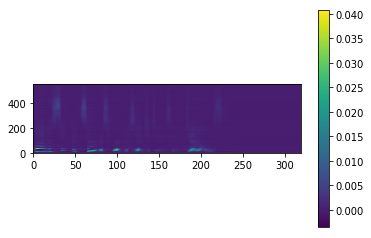

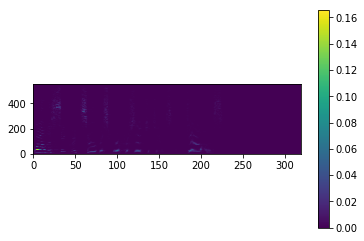

Time taken for an epoch #120: 11.1 sec
00h 04m 34s
tf.Tensor(0.047358863, shape=(), dtype=float32)


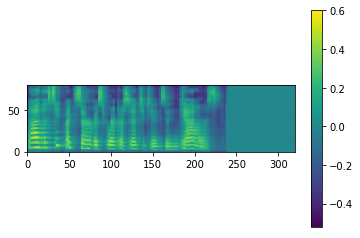

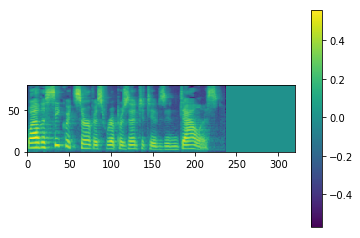

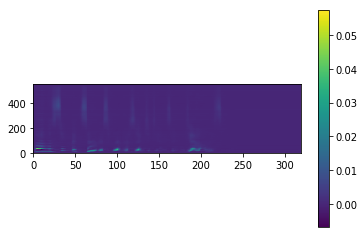

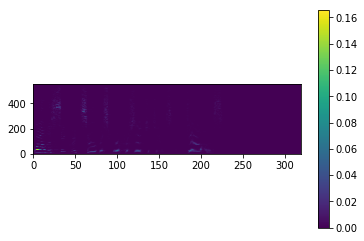

Time taken for an epoch #150: 11.1 sec
00h 10m 08s
tf.Tensor(0.045655098, shape=(), dtype=float32)


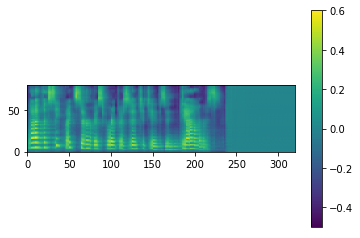

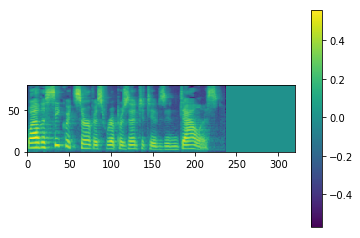

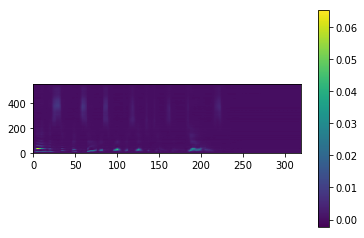

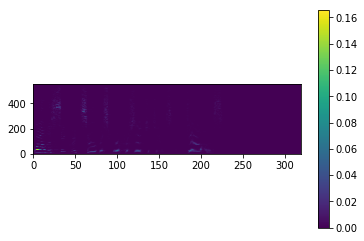

Time taken for an epoch #180: 11.1 sec
00h 15m 42s
tf.Tensor(0.04305812, shape=(), dtype=float32)


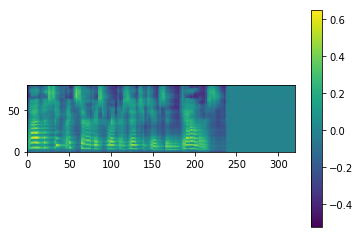

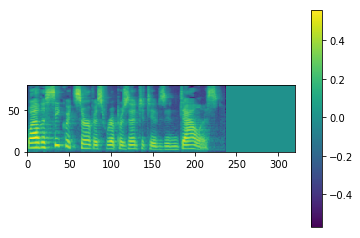

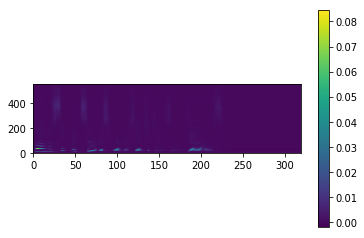

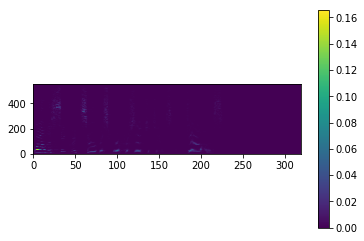

Time taken for an epoch #210: 11.2 sec
00h 21m 15s
tf.Tensor(0.041782014, shape=(), dtype=float32)


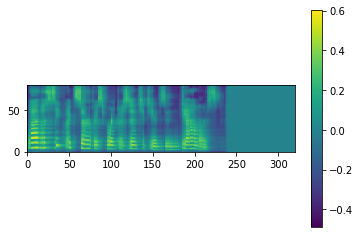

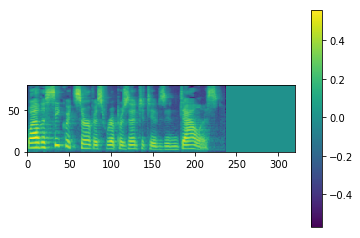

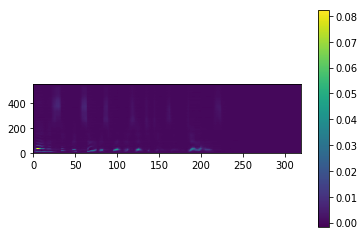

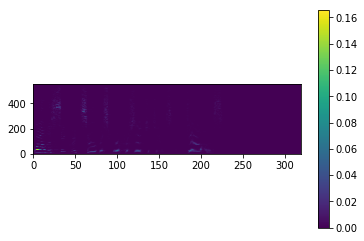

Time taken for an epoch #240: 11.1 sec
00h 26m 49s
tf.Tensor(0.03990136, shape=(), dtype=float32)


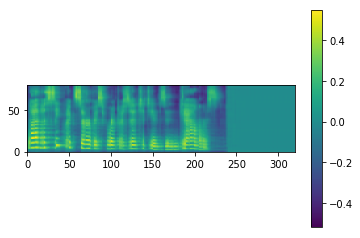

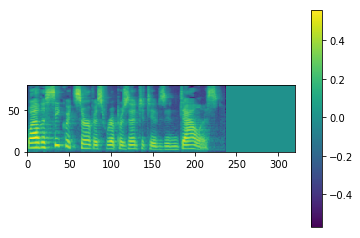

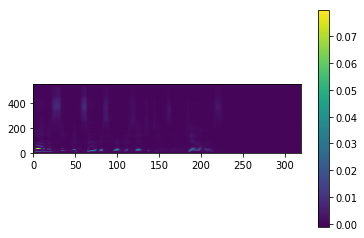

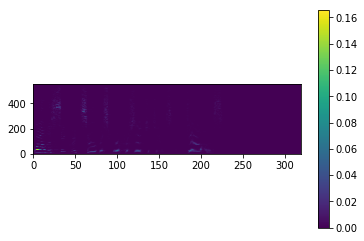

Time taken for an epoch #270: 11.2 sec
00h 32m 21s
tf.Tensor(0.039797325, shape=(), dtype=float32)


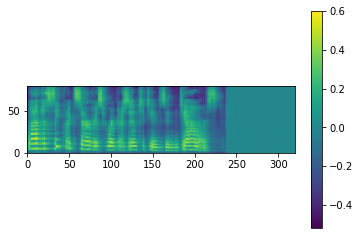

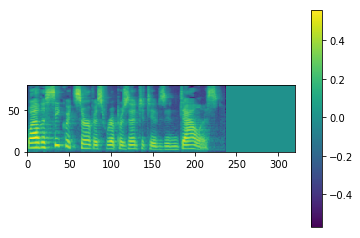

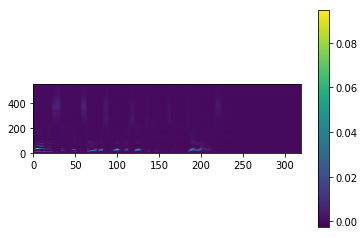

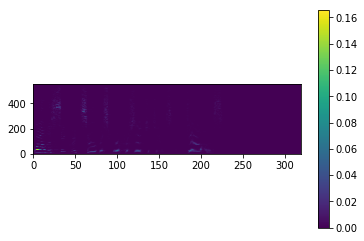

Time taken for an epoch #300: 11.0 sec
00h 37m 54s
tf.Tensor(0.038348638, shape=(), dtype=float32)


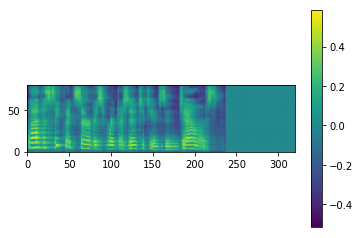

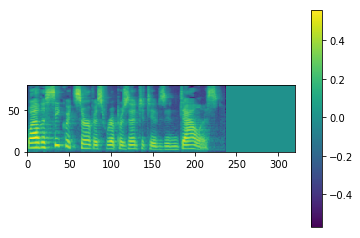

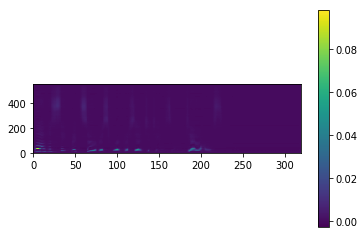

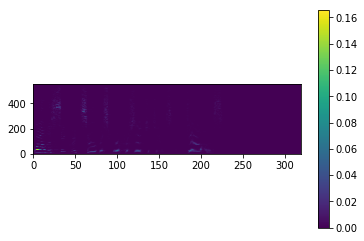

Time taken for an epoch #330: 11.1 sec
00h 43m 27s
tf.Tensor(0.037747554, shape=(), dtype=float32)


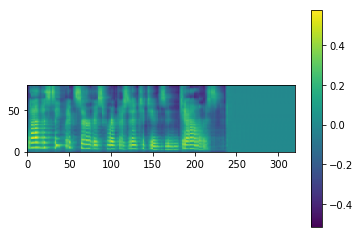

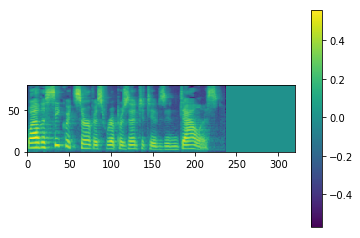

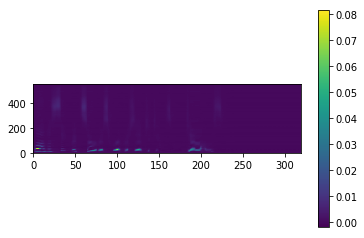

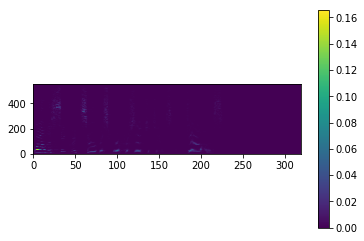

Time taken for an epoch #360: 11.1 sec
00h 49m 00s
tf.Tensor(0.037166625, shape=(), dtype=float32)


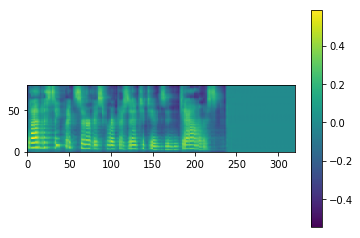

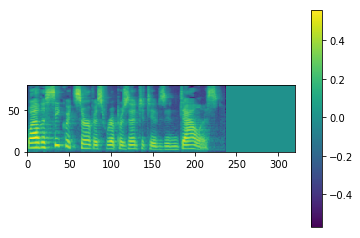

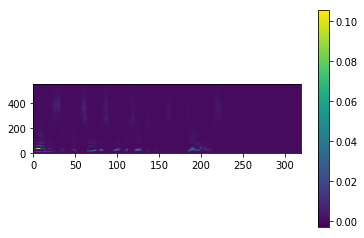

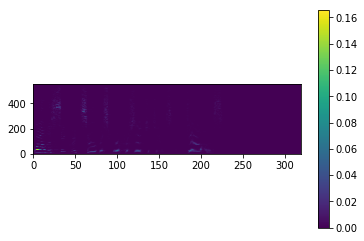

Time taken for an epoch #390: 11.1 sec
00h 54m 33s
tf.Tensor(0.03617231, shape=(), dtype=float32)


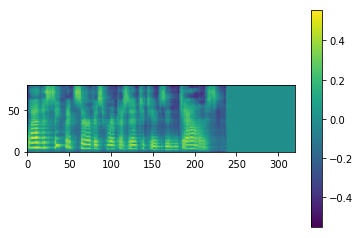

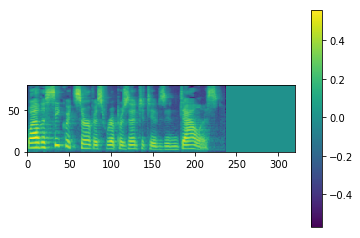

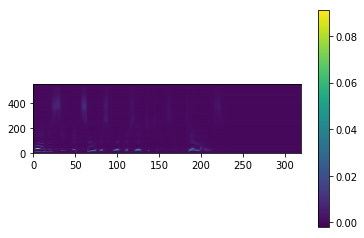

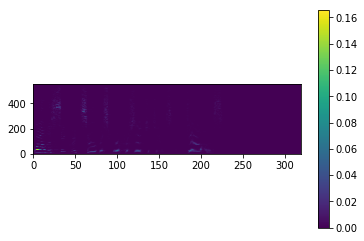

Time taken for an epoch #420: 11.1 sec
01h 00m 07s
tf.Tensor(0.036122896, shape=(), dtype=float32)


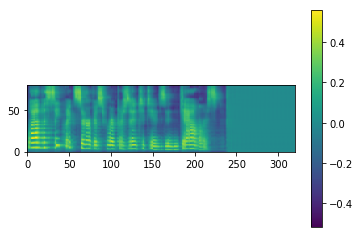

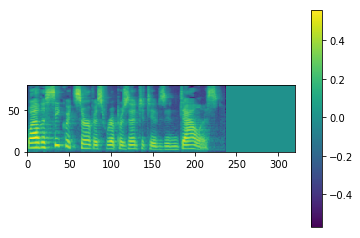

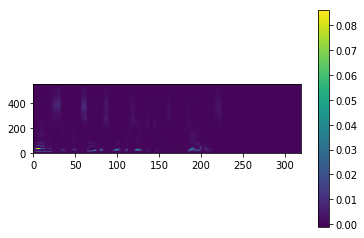

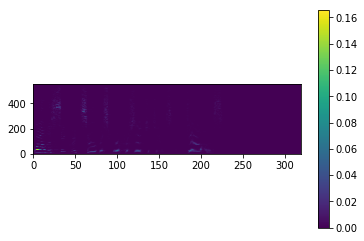

Time taken for an epoch #450: 11.1 sec
01h 05m 40s
tf.Tensor(0.035290528, shape=(), dtype=float32)


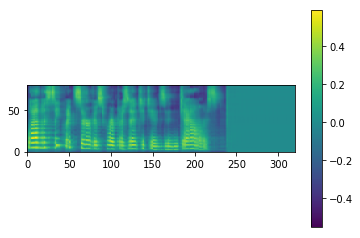

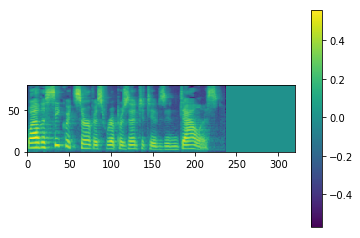

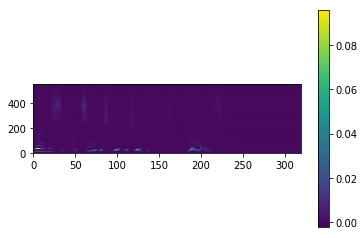

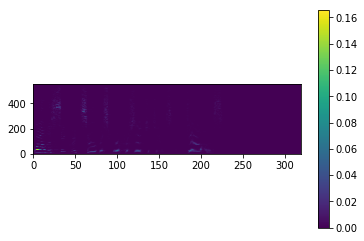

Time taken for an epoch #480: 11.1 sec
01h 11m 13s
tf.Tensor(0.03622814, shape=(), dtype=float32)


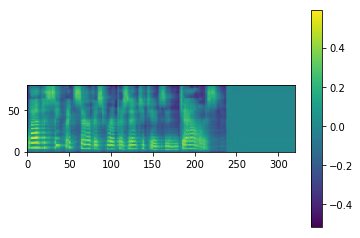

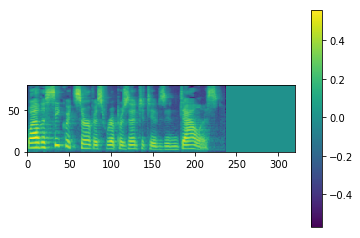

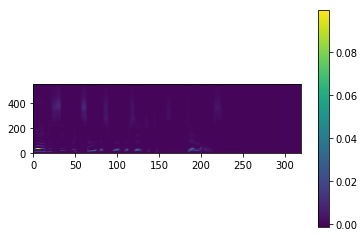

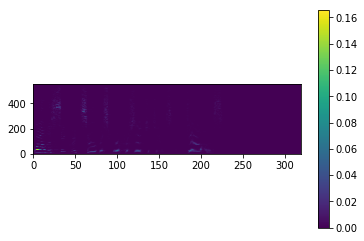

Time taken for an epoch #510: 11.1 sec
01h 16m 47s
tf.Tensor(0.034903605, shape=(), dtype=float32)


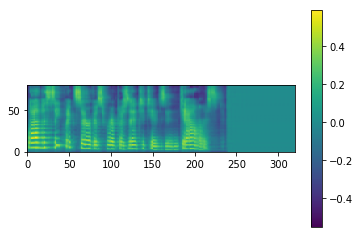

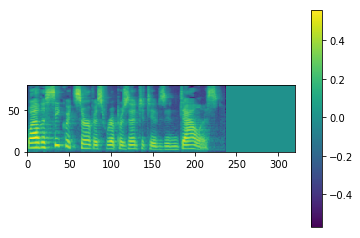

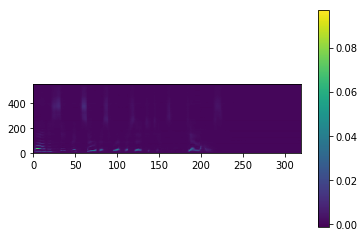

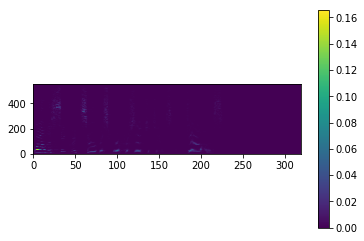

Time taken for an epoch #540: 11.0 sec
01h 22m 20s
tf.Tensor(0.03451729, shape=(), dtype=float32)


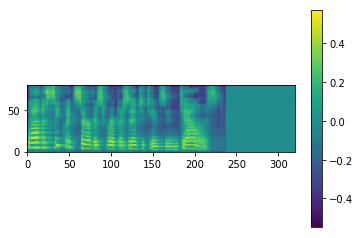

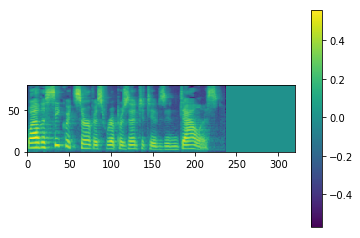

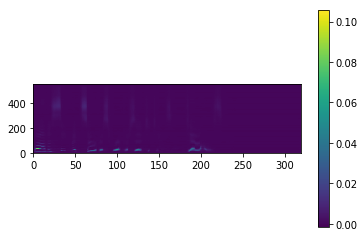

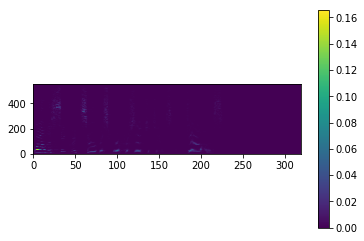

Time taken for an epoch #570: 11.1 sec
01h 27m 53s
tf.Tensor(0.034646027, shape=(), dtype=float32)


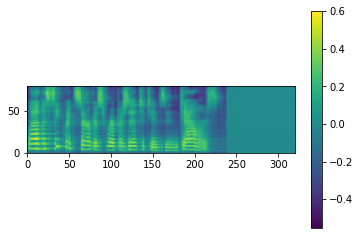

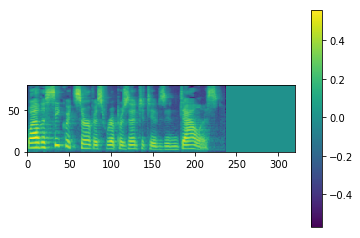

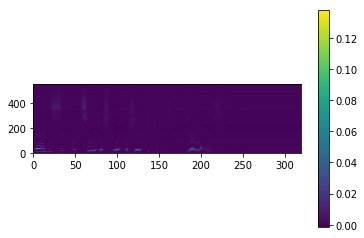

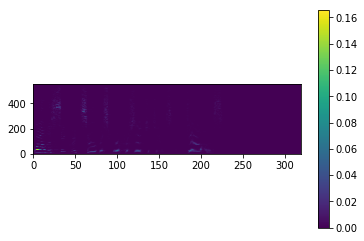

Time taken for an epoch #600: 11.1 sec
01h 33m 27s
tf.Tensor(0.033774894, shape=(), dtype=float32)


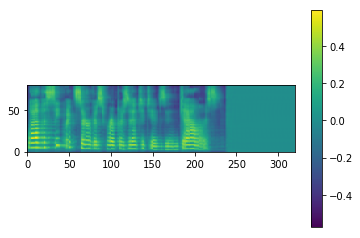

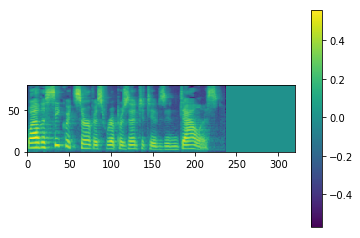

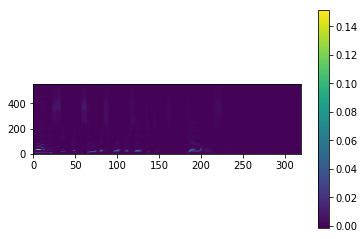

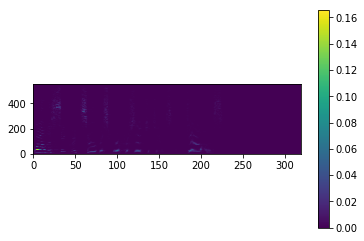

Time taken for an epoch #630: 11.1 sec
01h 39m 01s
tf.Tensor(0.033681612, shape=(), dtype=float32)


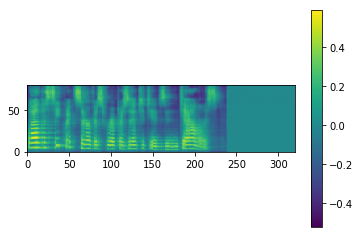

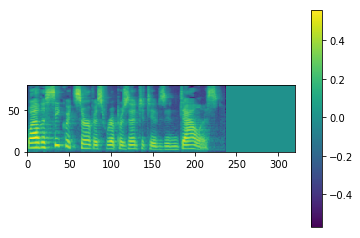

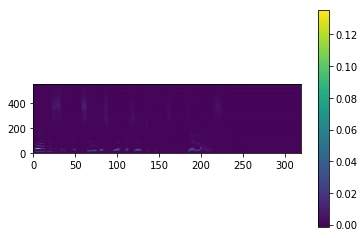

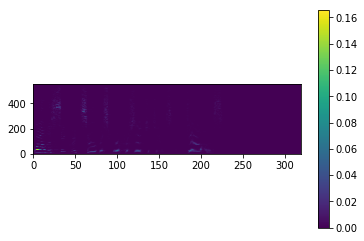

Time taken for an epoch #660: 11.7 sec
01h 44m 40s
tf.Tensor(0.03381326, shape=(), dtype=float32)


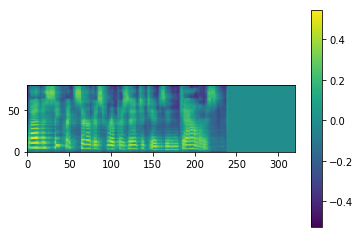

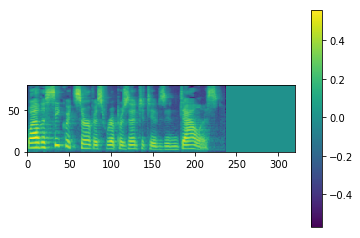

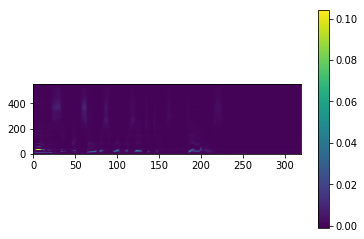

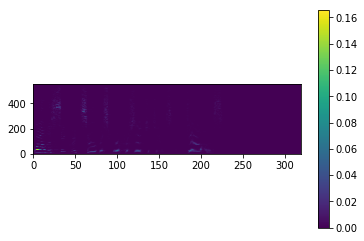

Time taken for an epoch #690: 11.6 sec
01h 50m 32s
tf.Tensor(0.033567324, shape=(), dtype=float32)


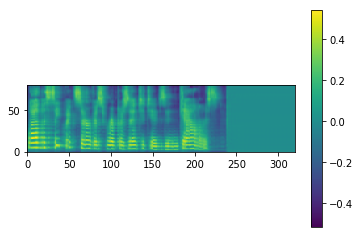

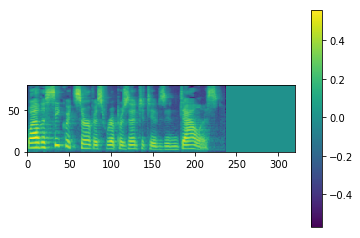

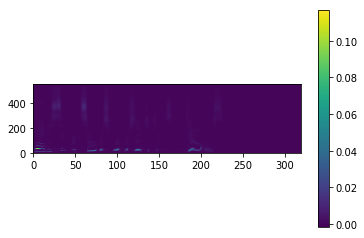

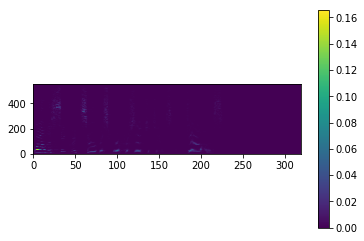

Time taken for an epoch #720: 11.7 sec
01h 56m 23s
tf.Tensor(0.03313498, shape=(), dtype=float32)


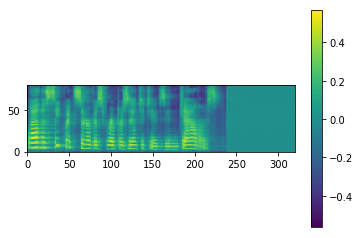

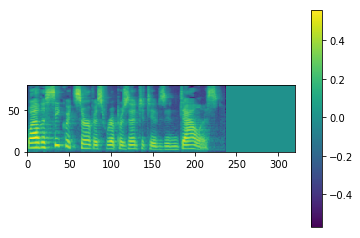

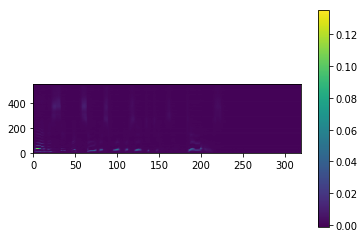

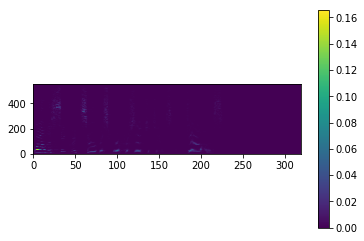

Time taken for an epoch #750: 11.8 sec
02h 02m 15s
tf.Tensor(0.033092517, shape=(), dtype=float32)


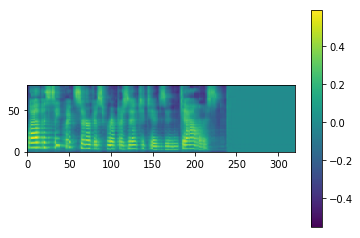

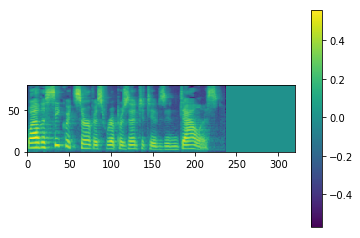

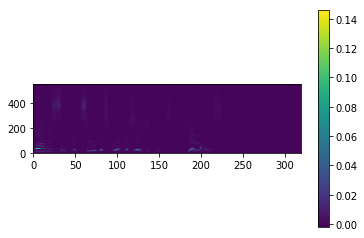

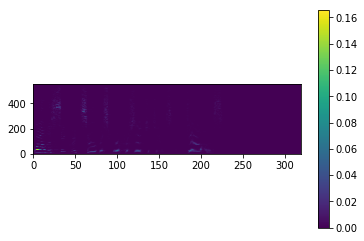

Time taken for an epoch #780: 11.8 sec
02h 08m 06s
tf.Tensor(0.034099396, shape=(), dtype=float32)


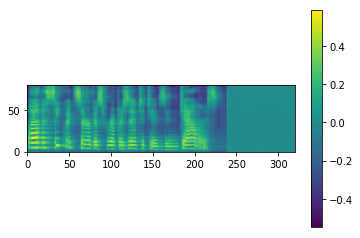

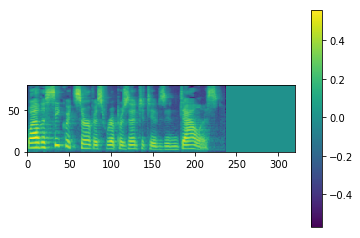

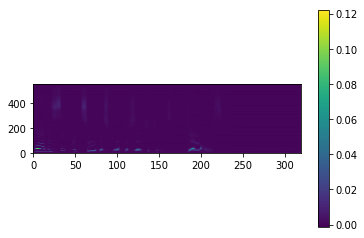

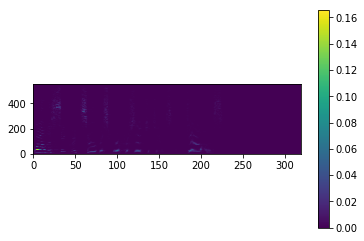

Time taken for an epoch #810: 11.8 sec
02h 13m 59s
tf.Tensor(0.034055404, shape=(), dtype=float32)


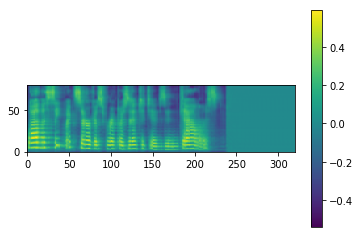

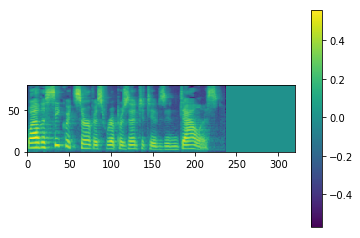

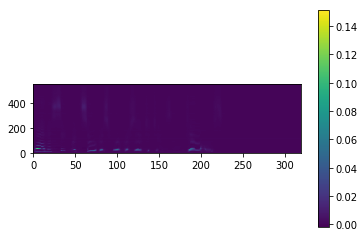

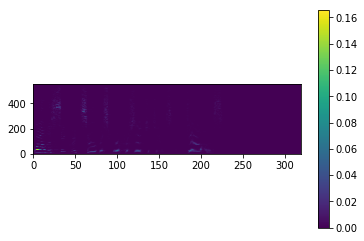

Time taken for an epoch #840: 11.6 sec
02h 19m 50s
tf.Tensor(0.033136435, shape=(), dtype=float32)


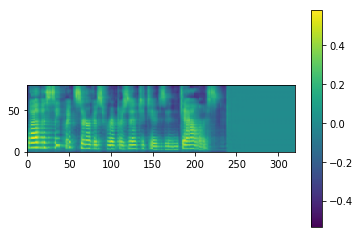

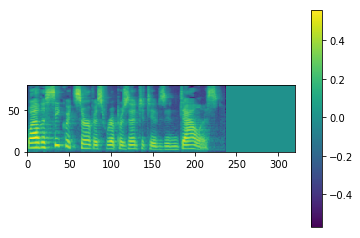

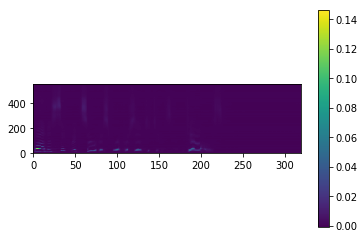

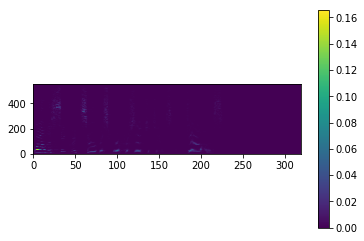

Time taken for an epoch #870: 11.7 sec
02h 25m 41s
tf.Tensor(0.032825783, shape=(), dtype=float32)


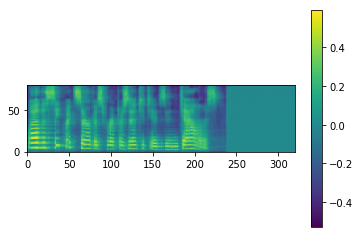

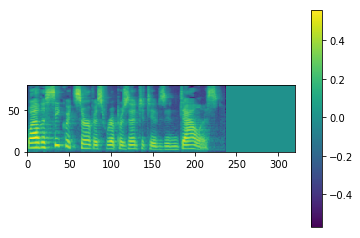

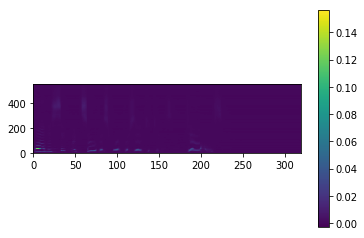

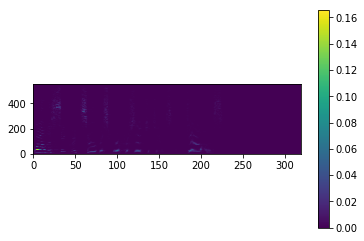

Time taken for an epoch #900: 11.6 sec
02h 31m 32s
tf.Tensor(0.03206589, shape=(), dtype=float32)


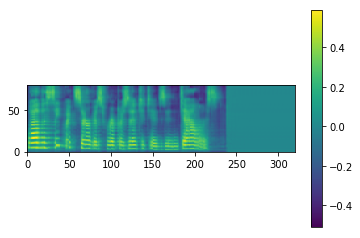

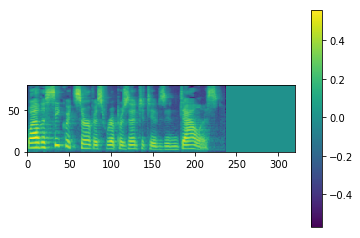

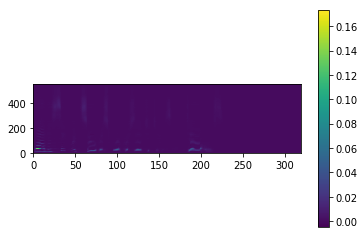

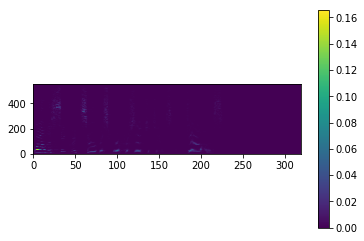

Time taken for an epoch #930: 11.7 sec
02h 37m 23s
tf.Tensor(0.032336608, shape=(), dtype=float32)


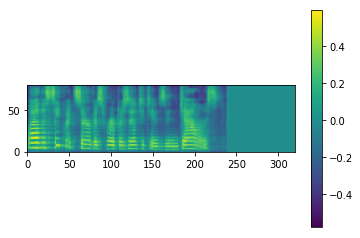

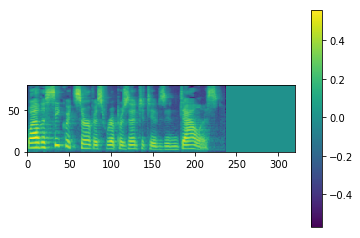

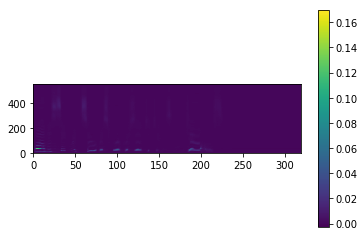

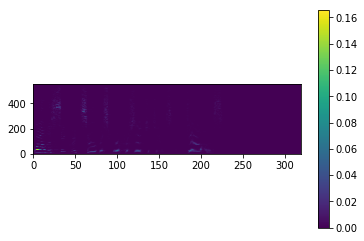

Time taken for an epoch #960: 11.7 sec
02h 43m 15s
tf.Tensor(0.031961065, shape=(), dtype=float32)


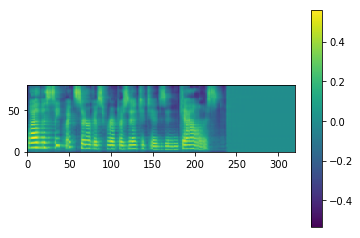

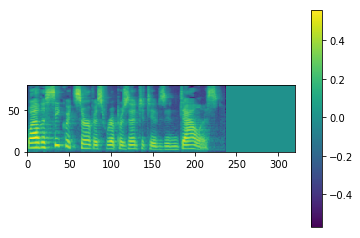

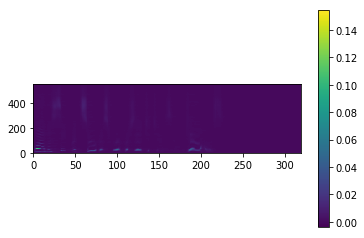

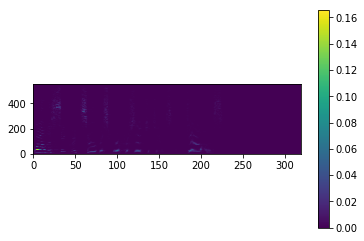

Time taken for an epoch #990: 11.7 sec
02h 49m 07s
tf.Tensor(0.031874426, shape=(), dtype=float32)


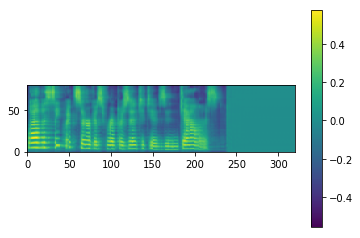

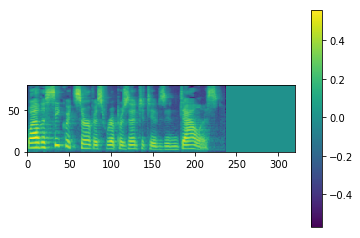

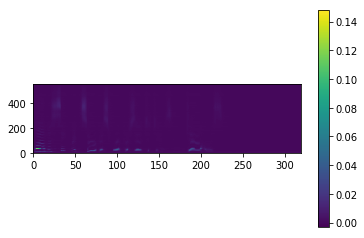

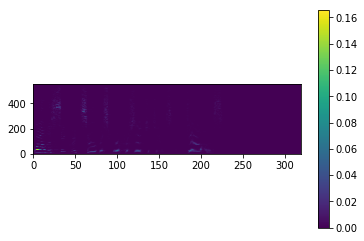

Time taken for an epoch #1020: 11.7 sec
02h 54m 58s
tf.Tensor(0.03189031, shape=(), dtype=float32)


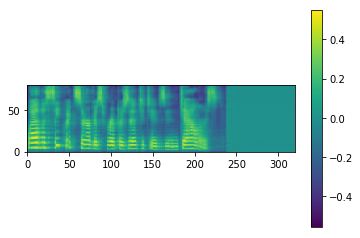

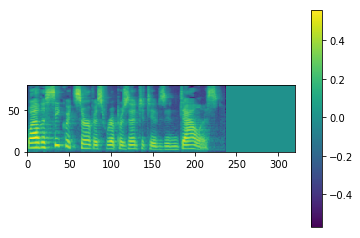

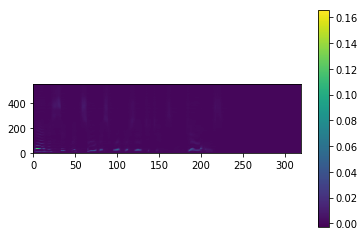

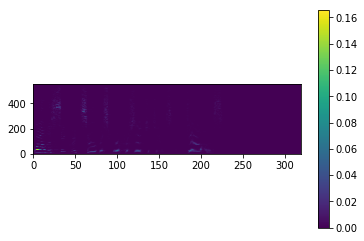

Time taken for an epoch #1050: 11.7 sec
03h 00m 49s
tf.Tensor(0.032392703, shape=(), dtype=float32)


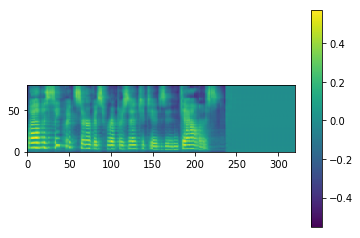

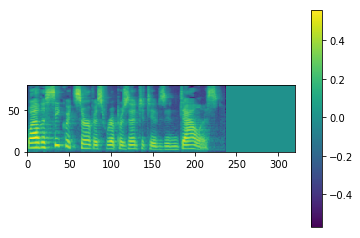

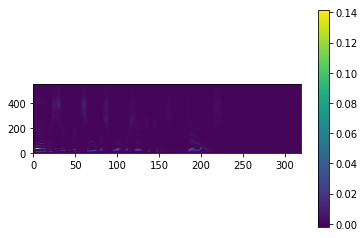

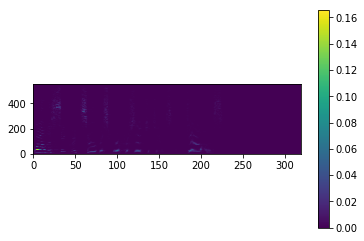

Time taken for an epoch #1080: 11.8 sec
03h 06m 42s
tf.Tensor(0.03211233, shape=(), dtype=float32)


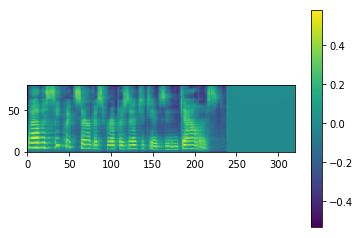

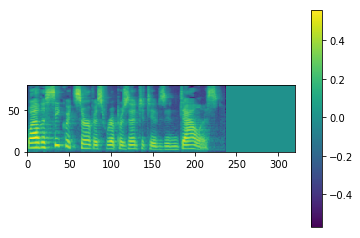

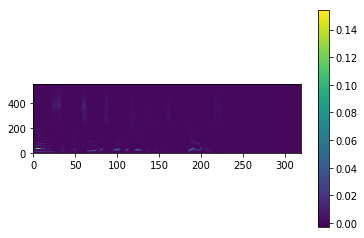

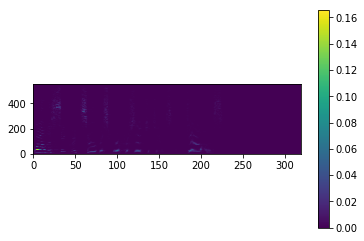

Time taken for an epoch #1110: 11.8 sec
03h 12m 33s
tf.Tensor(0.031601027, shape=(), dtype=float32)


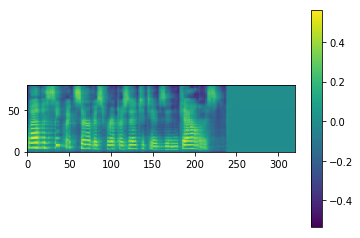

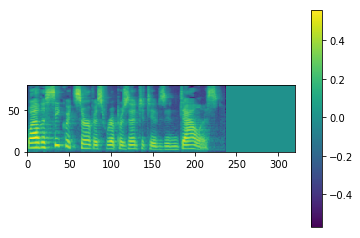

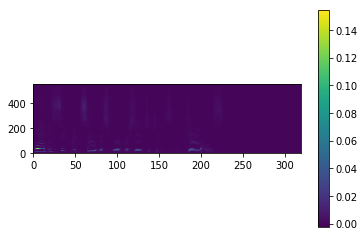

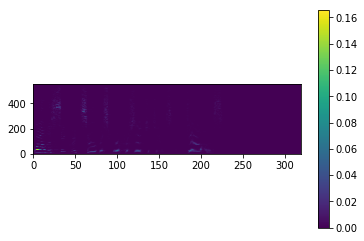

Time taken for an epoch #1140: 11.8 sec
03h 18m 25s
tf.Tensor(0.03213247, shape=(), dtype=float32)


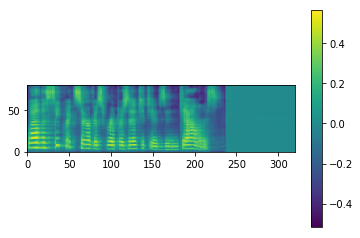

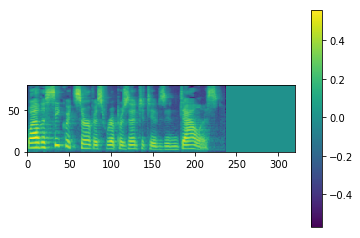

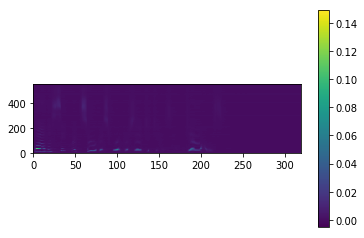

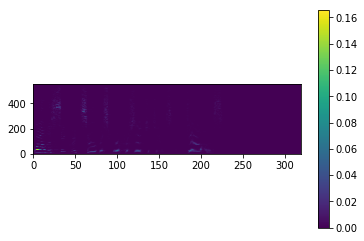

Time taken for an epoch #1170: 11.8 sec
03h 24m 17s
tf.Tensor(0.03166694, shape=(), dtype=float32)


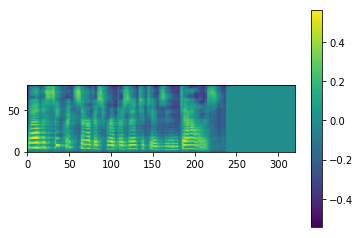

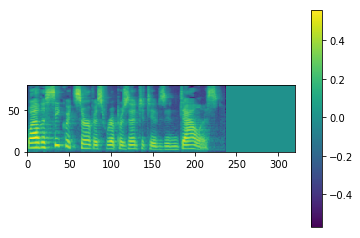

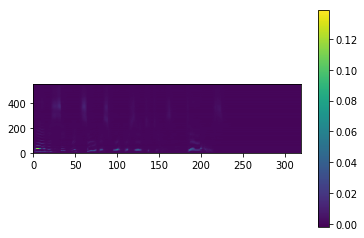

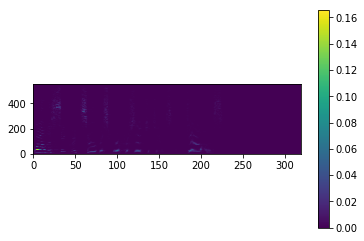

Time taken for an epoch #1200: 11.7 sec
03h 30m 09s
tf.Tensor(0.032097284, shape=(), dtype=float32)


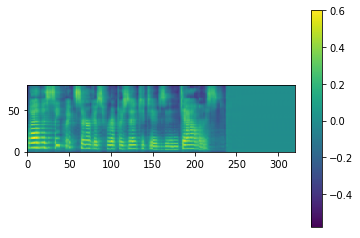

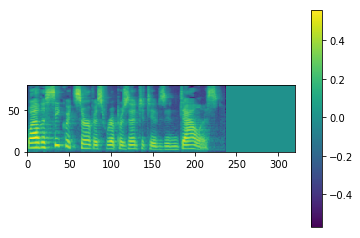

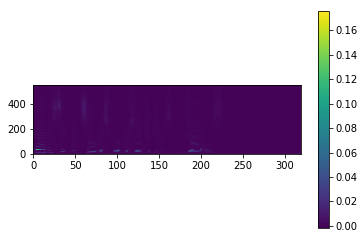

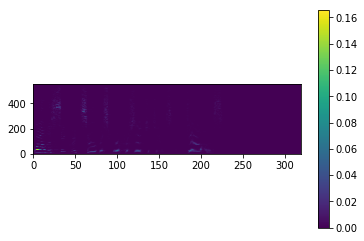

Time taken for an epoch #1230: 11.7 sec
03h 36m 01s
tf.Tensor(0.030846778, shape=(), dtype=float32)


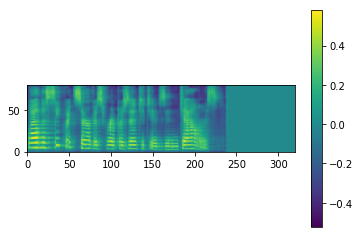

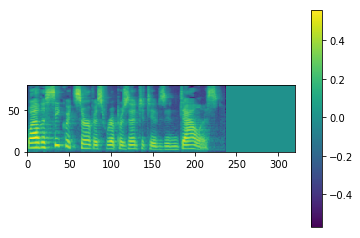

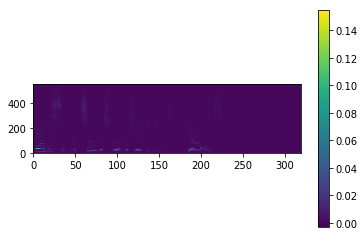

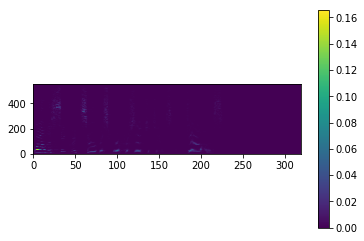

Time taken for an epoch #1260: 11.7 sec
03h 41m 52s
tf.Tensor(0.03135167, shape=(), dtype=float32)


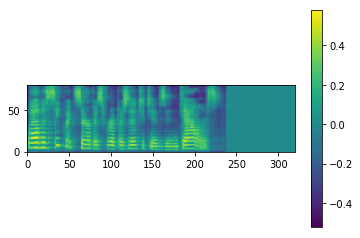

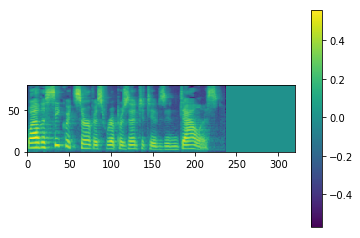

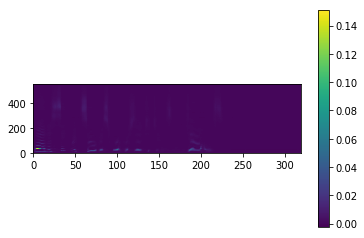

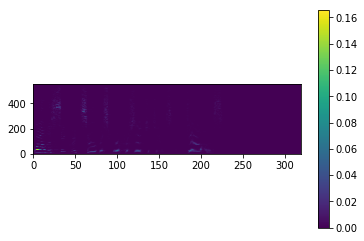

Time taken for an epoch #1290: 11.5 sec
03h 47m 43s
tf.Tensor(0.031292256, shape=(), dtype=float32)


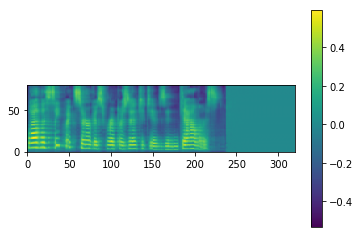

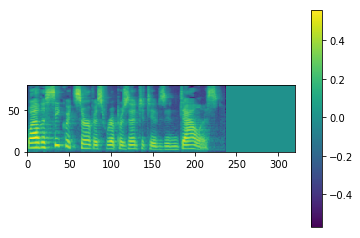

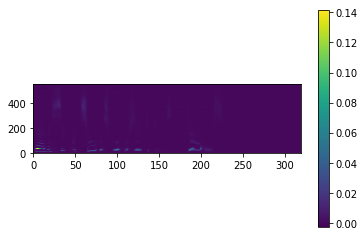

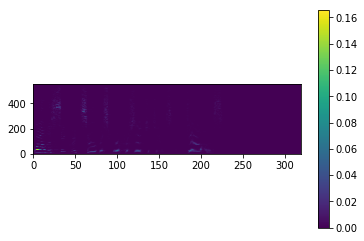

Time taken for an epoch #1320: 11.7 sec
03h 53m 34s
tf.Tensor(0.031021105, shape=(), dtype=float32)


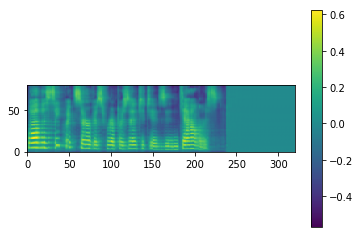

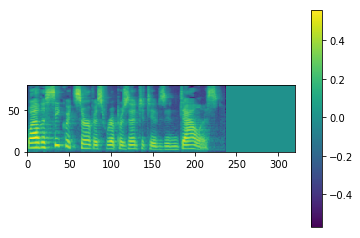

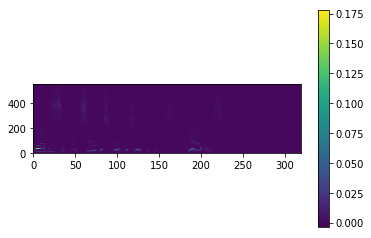

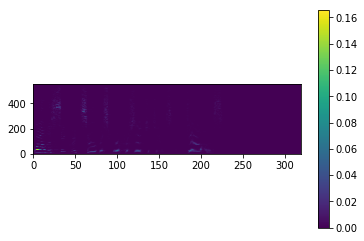

Time taken for an epoch #1350: 11.7 sec
03h 59m 26s
tf.Tensor(0.030757308, shape=(), dtype=float32)


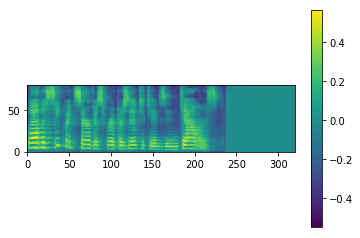

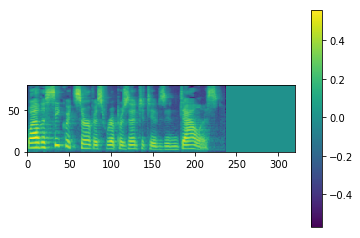

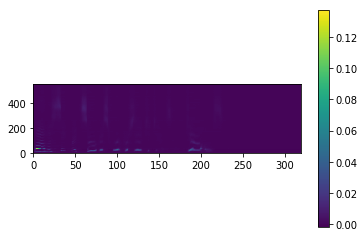

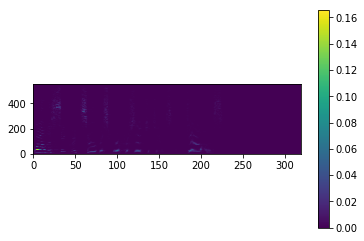

Time taken for an epoch #1380: 11.7 sec
04h 05m 18s
tf.Tensor(0.031104755, shape=(), dtype=float32)


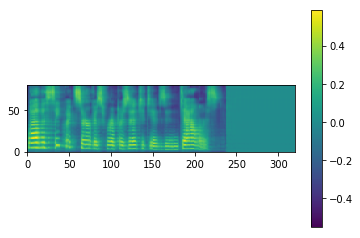

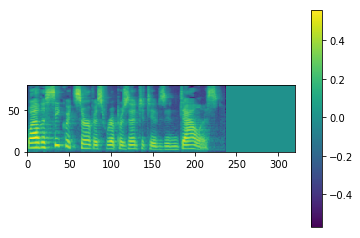

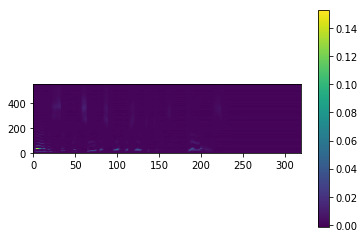

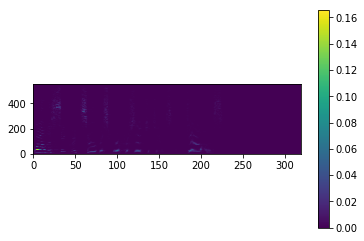

Time taken for an epoch #1410: 11.7 sec
04h 11m 10s
tf.Tensor(0.030436043, shape=(), dtype=float32)


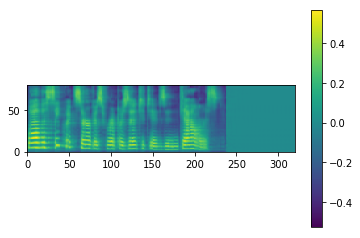

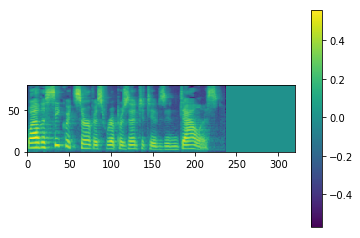

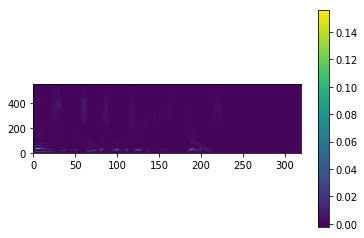

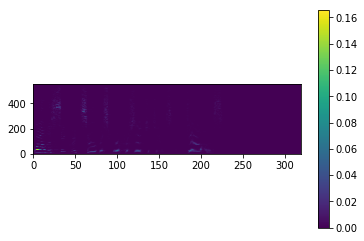

Time taken for an epoch #1440: 11.7 sec
04h 17m 01s
tf.Tensor(0.030671762, shape=(), dtype=float32)


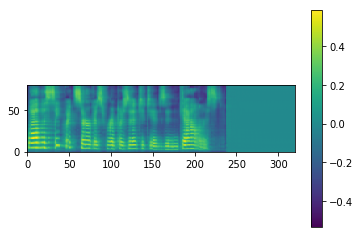

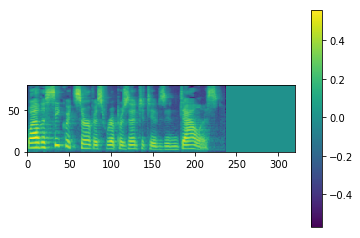

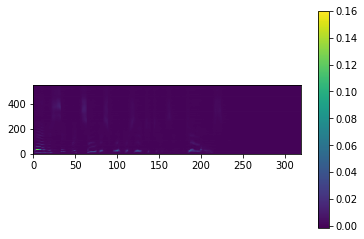

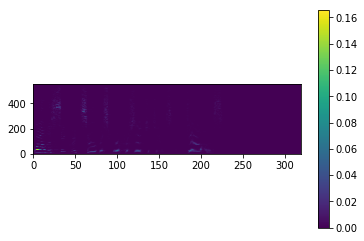

Time taken for an epoch #1470: 11.7 sec
04h 22m 54s
tf.Tensor(0.030538423, shape=(), dtype=float32)


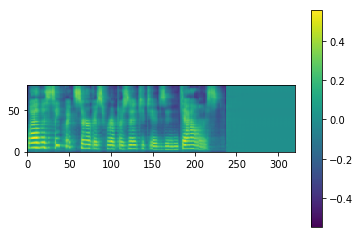

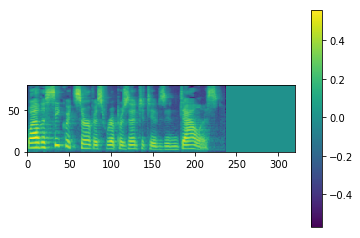

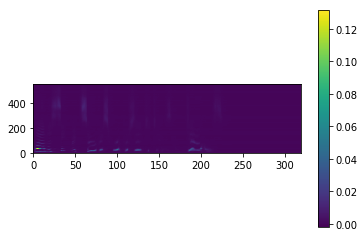

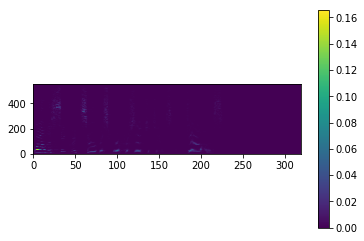

Time taken for an epoch #1500: 11.7 sec
04h 28m 46s
tf.Tensor(0.030364979, shape=(), dtype=float32)


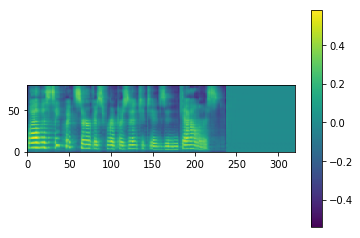

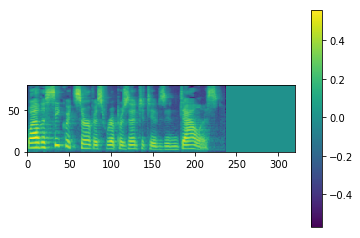

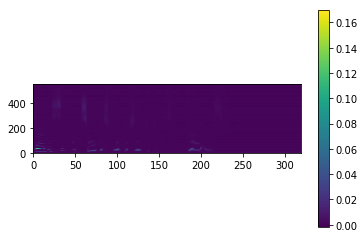

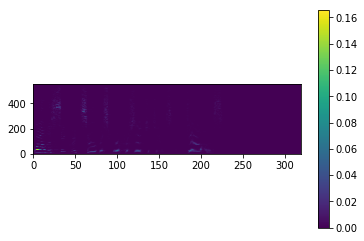

Time taken for an epoch #1530: 11.7 sec
04h 34m 38s
tf.Tensor(0.030531866, shape=(), dtype=float32)


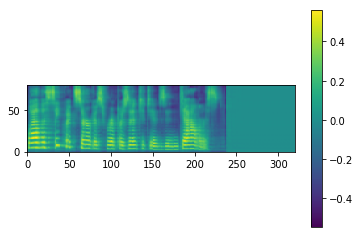

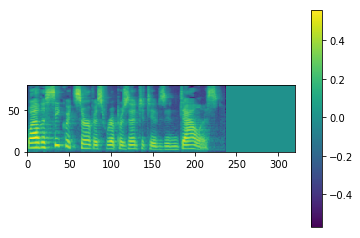

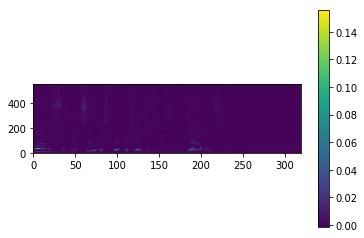

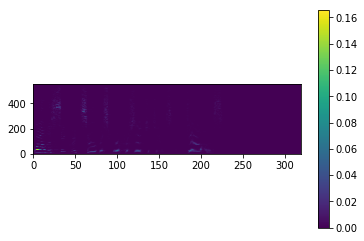

Time taken for an epoch #1560: 11.9 sec
04h 40m 29s
tf.Tensor(0.030183658, shape=(), dtype=float32)


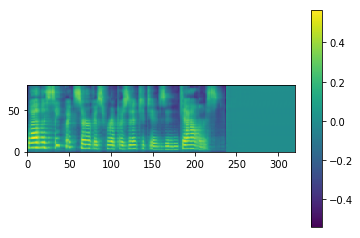

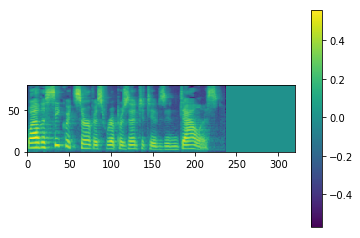

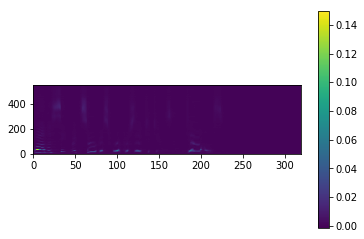

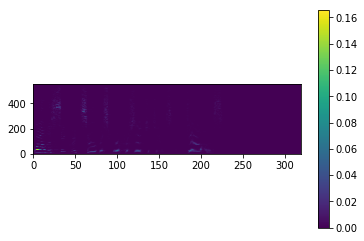

Time taken for an epoch #1590: 11.6 sec
04h 46m 21s
tf.Tensor(0.030454073, shape=(), dtype=float32)


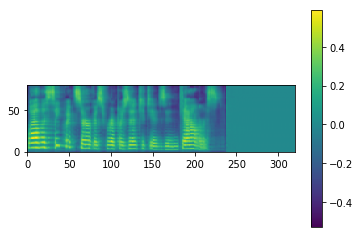

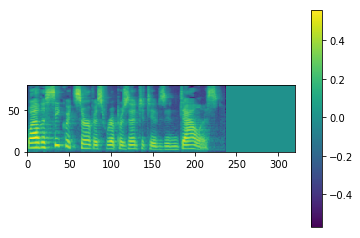

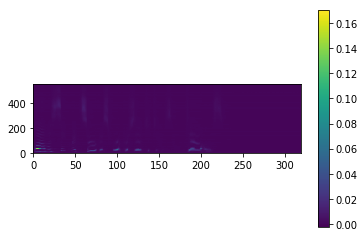

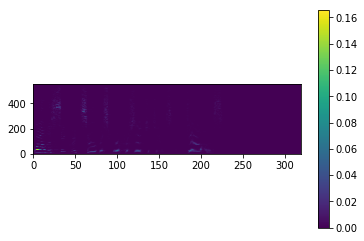

Time taken for an epoch #1620: 11.7 sec
04h 52m 13s
tf.Tensor(0.029963123, shape=(), dtype=float32)


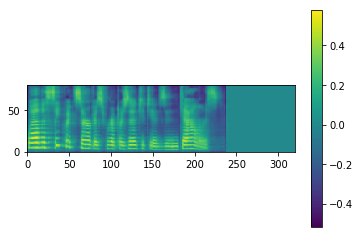

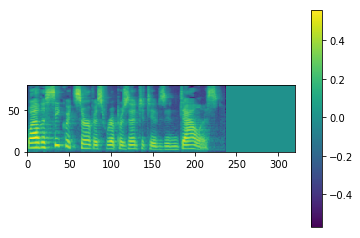

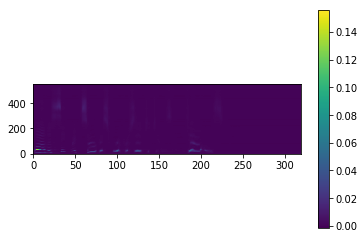

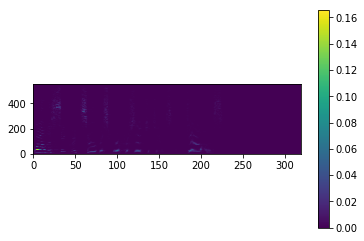

Time taken for an epoch #1650: 11.7 sec
04h 58m 04s
tf.Tensor(0.029945089, shape=(), dtype=float32)


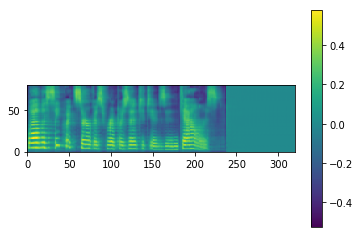

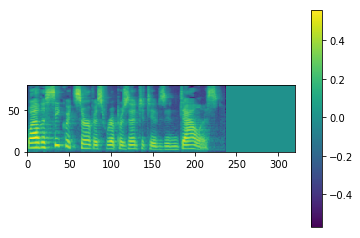

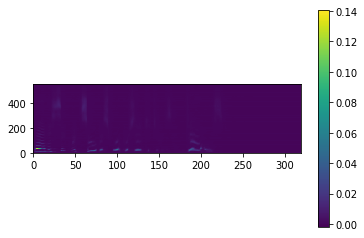

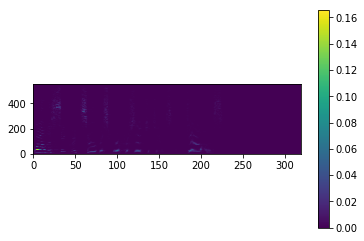

Time taken for an epoch #1680: 11.7 sec
05h 03m 55s
tf.Tensor(0.03043089, shape=(), dtype=float32)


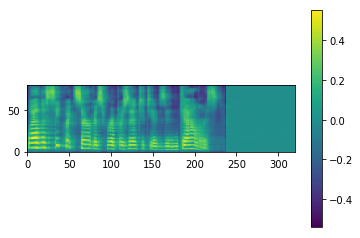

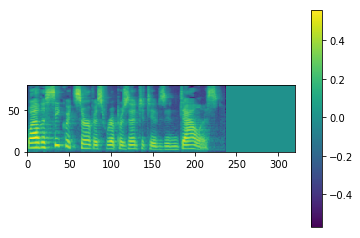

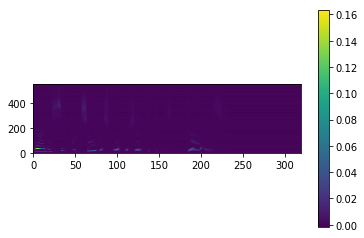

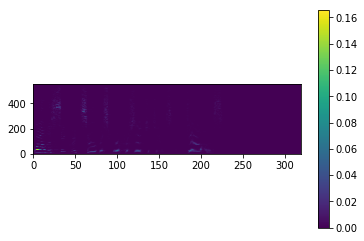

Time taken for an epoch #1710: 11.8 sec
05h 09m 47s
tf.Tensor(0.029983353, shape=(), dtype=float32)


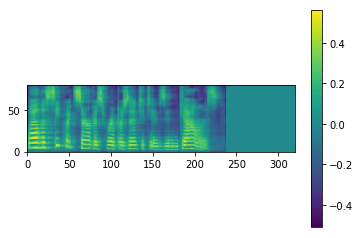

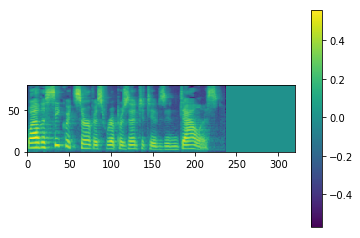

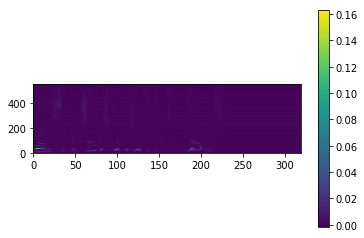

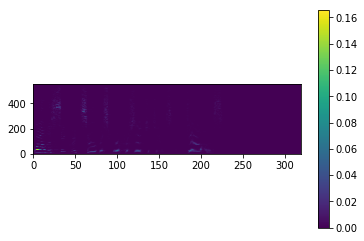

Time taken for an epoch #1740: 11.7 sec
05h 15m 38s
tf.Tensor(0.030699171, shape=(), dtype=float32)


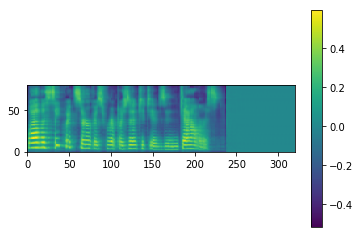

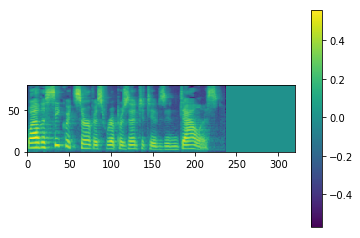

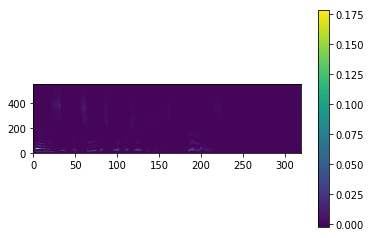

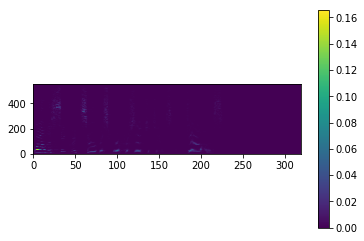

Time taken for an epoch #1770: 11.7 sec
05h 21m 30s
tf.Tensor(0.02975668, shape=(), dtype=float32)


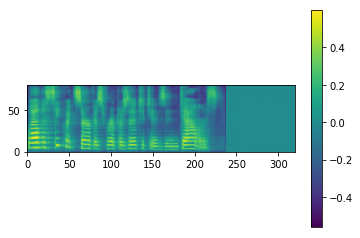

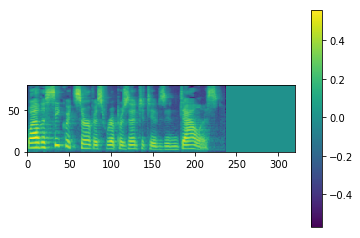

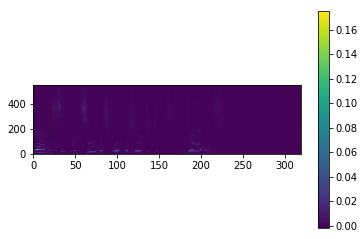

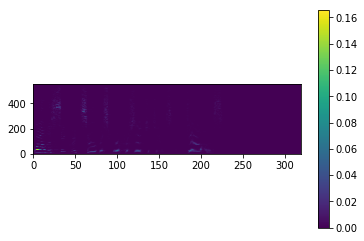

In [18]:
EPOCH = 1800

# Started hour
print(time.strftime("%Hh %Mm %Ss"))

for epochs in range(EPOCH):
    
    epoch_start = time.time()

    for i, (mel, linear, texts) in enumerate((dataset)):
        
        start = time.time()

#         print(texts.shape)    
        loss, images = tacotron.train(mel, linear, texts)

#         print('Time taken for a loop: {:.1f} sec'.format(time.time() - start))
#         print(time.strftime("%Hh %Mm %Ss"))
#         print('')

#         plt.imshow(tf.transpose(images[0]), origin='lower')
#         plt.colorbar()
#         plt.show()

#         plt.imshow(tf.transpose(images[2][:images[0].shape[0]]), origin='lower')
#         plt.colorbar()
#         plt.show()

#         plt.imshow(tf.transpose(images[1]), origin='lower')
#         plt.colorbar()
#         ax = plt.gca()
#         ax.set_aspect(0.15)
#         plt.show()

#         plt.imshow(tf.transpose(images[3][:images[1].shape[0]]), origin='lower')
#         plt.colorbar()
#         ax = plt.gca()
#         ax.set_aspect(0.15)
#         plt.show()
        
    if (epochs % 30 == 0):
    
        print('Time taken for an epoch #{}: {:.1f} sec'.format(epochs, time.time() - epoch_start))
        print(time.strftime("%Hh %Mm %Ss"))

        print(loss)

        plt.imshow(tf.transpose(images[0]), origin='lower')
        plt.colorbar()
        plt.show()

        plt.imshow(tf.transpose(images[2][:images[0].shape[0]]), origin='lower')
        plt.colorbar()
        plt.show()

        plt.imshow(tf.transpose(images[1]), origin='lower')
        plt.colorbar()
        ax = plt.gca()
        ax.set_aspect(0.15)
        plt.show()

        plt.imshow(tf.transpose(images[3][:images[1].shape[0]]), origin='lower')
        plt.colorbar()
        ax = plt.gca()
        ax.set_aspect(0.15)
        plt.show()

In [20]:
np.save('mel_true.npy', images[3])